In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
import optuna
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from scipy.optimize import minimize
import shap

from library.Data_Preprocessing import Balance_Ratio, training_def
from library.Imbalance_Sampling import label_divide, resampling_dataset
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### LightGBM

In [2]:
# classifier
def LightGBMC(train_x, test_x, train_y, test_y, config, return_prob = False):
    
    clf = LGBMClassifier(**config)
    clf.fit(train_x, train_y)
    predict_y = clf.predict_proba(test_x)[:, 1]
    define_predict = (predict_y > 0.5).astype(int)
    if return_prob:
        result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    else:
        result = pd.DataFrame({'truth': test_y, 'predict': define_predict})
    
    return result


# regressor (optional)
def LightGBMR(train_x, test_x, train_y, test_y, config):
    
    reg = LGBMRegressor(**config)
    reg.fit(train_x, train_y)
    predict_y = reg.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


# classifier for all resampling datasets 
def runall_LightGBMC(trainset_x, test_x, trainset_y, test_y, config):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    set_index = list(config.keys())
    judge = set_index[0]

    for i, j in tqdm(enumerate(set_index)):
        print('\n', f'Data{j}:')
        if isinstance(config[judge], dict) :
            best_config = config[j]
        else :
            best_config = config
        
        result = LightGBMC(trainset_x[j], test_x, trainset_y[j], test_y, best_config)
        table = cf_matrix(result, trainset_y[j])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'data{j}'})
        
    return table_set
    
    
# regressor for all resampling datasets (optional)
def runall_LightGBMR(num_set, trainset_x, test_x, trainset_y, test_y, config, thres_target = 'Recall', threshold = 0.8):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = LightGBMR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})

    return pr_dict, table_set

### Probability Calibration (optional)

In [ ]:
def stratified_data(train_data, cv):
    
    good = train_data[train_data.GB == 0]
    bad = train_data[train_data.GB == 1]
    good_index = random.sample(good.index.to_list(), k = len(good))
    bad_index = random.sample(bad.index.to_list(), k = len(bad))
    
    train_x_dict = {}
    train_y_dict = {}
    valid_x_dict = {}
    valid_y_dict = {}
    for i in range(cv):
        
        if (i+1) == cv:
            good_valid_index = good_index[int(np.floor((i/cv)*len(good))): ]
            bad_valid_index = bad_index[int(np.floor((i/cv)*len(bad))): ]
        else:
            good_valid_index = good_index[int(np.floor((i/cv)*len(good))) : int(np.floor(((i+1)/cv)*len(good)))]
            bad_valid_index = bad_index[int(np.floor((i/cv)*len(bad))) : int(np.floor(((i+1)/cv)*len(bad)))]
        good_train_index = [x for x in good_index if x not in good_valid_index]
        bad_train_index = [x for x in bad_index if x not in bad_valid_index]
        
        good_train = good.loc[good_train_index]
        good_valid = good.loc[good_valid_index]
        bad_train = bad.loc[bad_train_index]
        bad_valid = bad.loc[bad_valid_index]
        train = pd.concat([good_train, bad_train], axis = 0)
        valid = pd.concat([good_valid, bad_valid], axis = 0)
        train_x_dict[i], train_y_dict[i], valid_x_dict[i], valid_y_dict[i] = label_divide(train, valid, train_only = False)

    return train_x_dict, train_y_dict, valid_x_dict, valid_y_dict


def beta_map(s, a, b, c):
    return 1 / (1 + 1 / (np.power(np.exp(1), c)*(np.power(s, a) / np.power(1-s, b))))
                

def self_loss(three, test_y, predict_y):
    a, b, c = three
    new_s = beta_map(predict_y, a, b, c)
    loss = np.mean(test_y*np.log(new_s) + (1 - test_y)*np.log(1 - new_s))*(-1)
    return loss


def beta_LightGBMC(train_x, train_y, test_x, test_y, config, loss_function = self_loss):
    
    train = pd.concat([train_x, train_y], axis = 1)
    train_x_dict, train_y_dict, valid_x_dict, valid_y_dict = stratified_data(train, cv = 5)
    
    cali_param = {}
    for i in range(len(train_x_dict)):
        clf = LGBMClassifier(**config)
        clf.fit(train_x_dict[i], train_y_dict[i])
        predict_y = clf.predict_proba(valid_x_dict[i])[:, 1]
        mini_result = minimize(loss_function, [0.5, 0.5, 0.5], (valid_y_dict[i], predict_y))
        cali_param[i] = mini_result.x
        
    clf = LGBMClassifier(**config)
    clf.fit(train_x, train_y)
    predict_y = clf.predict_proba(test_x)[:, 1]
    
    cali_predict = np.array(0).astype(float)
    for i in range(len(cali_param)):
        cali_result = beta_map(predict_y, *cali_param[i])
        cali_predict = cali_predict + cali_result
    cali_predict /= len(cali_param)
      
    predict = (cali_predict > 0.5).astype(int)
    result = pd.DataFrame({'truth': test_y, 'predict': predict})

    return result


def cali_LightGBMC(train_x, train_y, test_x, test_y, config, method):
    
    clf = LGBMClassifier(**config)
    cali_clf = CalibratedClassifierCV(clf, method = method, cv = 5)
    cali_clf.fit(train_x, train_y)
    predict_y = cali_clf.predict_proba(test_x)[:, 1]
    predict = (predict_y > 0.5).astype(int)
    result = pd.DataFrame({'truth': test_y, 'predict': predict})
    
    return result 


def all_cali_LightGBMC(trainset_x, trainset_y, test_x, test_y, config_dict, method):
    
    keys = config_dict.keys()
    all_result = pd.DataFrame()
    for i in keys:
        print('\n', f'Data{i}:')
        
        if method in ['isotonic', 'sigmoid']:
            table = cali_LightGBMC(trainset_x[i], trainset_y[i], test_x, test_y, config_dict[i], method)
        elif method == 'beta':
            table = beta_LightGBMC(trainset_x[i], trainset_y[i], test_x, test_y, config_dict[i])
        result_df = cf_matrix(table, trainset_y[i])
        all_result = pd.concat([all_result, result_df], axis = 0).rename(index = {0: f'data{i}'})
        
    return all_result

### Optuna

In [3]:
# creator of optuna study for LightGBM
def LightGBM_creator(train_data, mode, num_valid = 5, label = 'GB') :

    def objective(trial) :
    
        param = {
            'n_estimators': trial.suggest_categorical('n_estimators', [100, 300, 500, 1000]),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.325, step = 0.05),
            'max_depth': trial.suggest_int('max_depth', 3, 15, step = 3),
            'num_leaves': trial.suggest_int('num_leaves', 10, 150, step = 20),
            'min_child_samples': trial.suggest_categorical('min_child_samples', [10, 50, 100, 500, 1000, 5000]),
            'min_split_gain': trial.suggest_int('min_split_gain', 0, 12, step = 2),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9, step = 0.2),
            'subsample': trial.suggest_float('subsample', 0.3, 0.9, step = 0.2),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10), # alpha
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10) # lambda
        }

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)

            if mode == 'C':
                result = LightGBMC(train_x, valid_x, train_y, valid_y, param)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                precision = table['Precision']
                beta = 1
                if recall.values > 0:
                    fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision)
                else:
                    fscore = 0
                result_list.append(fscore)

            elif mode == 'R':
                result = LightGBMR(train_x, valid_x, train_y, valid_y, param)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)

    return objective

### Full Experiment

In [4]:
def full_lightgbm(train_month, times):
    best_param = dict()
    all_score = dict()
    prob_dict = dict()
    result_df = pd.DataFrame()

    # load relabel datasets
    runhist = {}
    kinds = {}
    for i in train_month:
        runhist[f'm{i}'] = pd.read_csv(f'relabel_runhist_m{i}.csv', index_col = 'id').iloc[:, 1:]
        kinds[f'm{i}'] = pd.read_csv(f'kind_m{i}.csv').iloc[:, 2:-3]

    #  do several times to average the random effect of resampling
    for i in tqdm(range(times)):
        # generate resampled datasets
        resampling_dataset(runhist = runhist, kinds = kinds, train_month = train_month, final_br = 1, num_os = 10)

        # load & prepare the resampled datasets 
        all_train = multiple_set(num_set = 10)
        all_train_x, all_train_y = train_set(all_train)
        all_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
        all_test_x, all_test_y = label_divide(all_test, None, 'GB', train_only = True)

        # searching for hyperparameters
        best_param[i], all_score[i] = all_optuna(all_data = all_train, 
                                         mode = 'C', 
                                         TPE_multi = False, 
                                         n_iter = 25, 
                                         filename = f'runhist_array_m2m4_m5_3criteria_LightGBM_{i}',
                                         creator = LightGBM_creator
                                        )
        # store the probability predicted by the classifier 
        for j in best_param[i].keys():
            if i == 0:
                prob_dict[j] = pd.DataFrame()
            table = LightGBMC(all_train_x[j], all_test_x, all_train_y[j], all_test_y, best_param[i][j], return_prob = True)
            prob_dict[j] = pd.concat([prob_dict[j], table[['predict']]], axis = 1)
            
    # average to get final prediction
    for j in best_param[0].keys():
        prediction = (prob_dict[j].apply(np.sum, axis = 1) >= 0.5).astype(int)
        result = pd.DataFrame(dict(truth = all_test_y, predict = prediction))
        table = cf_matrix(result, all_train_y[j])
        result_df = pd.concat([result_df, table]).rename(index = {0: f'data{j}'})
        
    return result_df

## Prediction

### For a Run

#### Load Data

In [ ]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)

#### Search for The Best Hyperparameters

In [ ]:
best_paramC, all_scoreC = all_optuna(all_data = run_train, 
                                     mode = 'C', 
                                     TPE_multi = False, 
                                     n_iter = 25,
                                     filename = 'runhist_array_m2m4_m5_3criteria_LightGBM',
                                     creator = LightGBM_creator
                                    )

In [ ]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 3, num_col = 3, model = 'LightGBM Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

#### Classifier

In [ ]:
table_setC = runall_LightGBMC(run_train_x, run_test_x, run_train_y, run_test_y, best_paramC)
line_chart(table_setC, title = 'LightGBM Classifier')

In [ ]:
table_setC

#### Calibrated Classifier (optional)

In [ ]:
tableC_1 = all_cali_LightGBMC(run_train_x, run_train_y, run_test_x, run_test_y, best_paramC, method = 'isotonic')
tableC_2 = all_cali_LightGBMC(run_train_x, run_train_y, run_test_x, run_test_y, best_paramC, method = 'sigmoid')
tableC_3 = all_cali_LightGBMC(run_train_x, run_train_y, run_test_x, run_test_y, best_paramC, method = 'beta')

#### Feature Importance

In [ ]:
target = 'set4'

d_train = lgb.Dataset(run_train_x[target], label = run_train_y[target])
d_test = lgb.Dataset(run_test_x, label = run_test_y)
model = lgb.train(best_paramC[target], d_train, 10000, valid_sets = [d_test], early_stopping_rounds = 50, verbose_eval=1000)
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(run_train_x[target])
values = abs(shap_value.values).mean(axis = 0)[:, 1]

shap.summary_plot(shap_values, run_train_x[target])
shap.dependence_plot('label_eqp_ADIEX600', shap_values[1], run_train_x[target])
shap.dependence_plot('label_eqp_ADSPT200', shap_values[1], run_train_x[target], color = shap_values)

In [ ]:
fig = plt.figure(figsize = (24, 8))
colname = run_train[target].columns.to_list()[:-1]
clf = LGBMClassifier(**best_paramC[target])
clf.fit(run_train_x[target], run_train_y[target])
importance = (clf.feature_importances_ / best_paramC[target]['n_estimators']).tolist()
plt.bar(colname, values, color = 'red')
plt.xticks(rotation = 90)
plt.title('20211228_LightGBM_ShapValue')
fig = plt.figure(figsize = (24, 8))
plt.bar(colname, importance, color = 'blue')
plt.xticks(rotation = 90)
plt.title('LightGBM_TreeBasedImportance')

#### Regressor (optional)

In [ ]:
best_paramR, all_scoreR = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'R', 
                                     TPE_multi = False, 
                                     n_iter = 10,
                                     filename = 'runhist_array_m2m5_4selection_LightGBM',
                                     creator = LightGBM_creator
                                    )

In [ ]:
pr_dict, table_setR = runall_LightGBMR(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramR, 
                                       thres_target = 'Recall', threshold = 0.7)
line_chart(table_setR, title = 'LightGBM Regressor')

In [ ]:
multiple_curve(4, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(4, 3, pr_dict, table_setR, target = 'Precision')
table_setR

### Full Experiment

In [5]:
training_month = range(2, 5)
table_setC = full_lightgbm(training_month, times = 3)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 155
# over: 155
Size after Border: 39625

 Generating Dataset 2
Size after Undersampling: 1370
Size after Undersampling: (1370, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-09 10:42:14,351] A new study created in memory with name: no-name-ff0b962c-535b-46f3-8a4c-af8415bae7d2


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8947368421052632 
Recall: 0.864406779661017 
Aging Rate: 0.4830508474576271
Precision: 0.8783592644978784 
Recall: 0.8096479791395046 
Aging Rate: 0.46088657105606257
Precision: 0.8770491803278688 
Recall: 0.8370273794002607 
Aging Rate: 0.4771838331160365
[I 2022-05-09 10:42:14,647] Trial 0 finished with value: 0.8594955160768293 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 7.384694570208793, 'reg_lambda': 0.02283797041190419}. Best is trial 0 with value: 0.8594955160768293.
Precision: 0.920881971465629 
Recall: 0.9256844850065189 
Aging Rate: 0.5026075619295959
Precision: 0.9240837696335078 
Recall: 0.9204693611473272 
Aging Rate: 0.4980443285528031
Precision: 0.9211563731931669 
Recall: 0.9139504563233377 
Aging Rate: 0.49608865710560623
[I 2022-05-09 10:42:15,366] Trial 1 finished with value: 0.9210297580926153 and p

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:42:15,616] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.47914791767781356, 'reg_lambda': 7.379331989140405}. Best is trial 1 with value: 0.9210297580926153.
Precision: 0.9316129032258065 
Recall: 0.9413298565840938 
Aging Rate: 0.5052151238591917
Precision: 0.9516778523489933 
Recall: 0.924380704041721 
Aging Rate: 0.48565840938722293
Precision: 0.9430051813471503 
Recall: 0.9491525423728814 
Aging Rate: 0.5032594524119948
[I 2022-05-09 10:42:15,922] Trial 3 finished with value: 0.9401152458414614 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:42:16,795] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.01299079383480432, 'reg_lambda': 0.013367337047100764}. Best is trial 3 with value: 0.9401152458414614.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:42:17,007] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.052733994070027074, 'reg_lambda': 5.413122148188021}. Best is trial 3 with value: 0.9401152458414614.
Precision: 0.8628808864265928 
Recall: 0.8122555410691004 
Aging Rate: 0.4706649282920469
Precision: 0.8543956043956044 
Recall: 0.8109517601043025 
Aging Rate: 0.4745762711864407
Precision: 0.8734693877551021 
Recall: 0.8370273794002607 
Aging Rate: 0.4791395045632334
[I 2022-05-09 10:42:17,299] Trial 8 finished with value: 0.8412568111565024 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 500, 'min_split_gain': 6, '

Precision: 0.8967391304347826 
Recall: 0.8604954367666232 
Aging Rate: 0.47979139504563234
Precision: 0.881491344873502 
Recall: 0.863102998696219 
Aging Rate: 0.4895697522816167
Precision: 0.9112903225806451 
Recall: 0.8839634941329857 
Aging Rate: 0.485006518904824
[I 2022-05-09 10:42:22,726] Trial 20 finished with value: 0.882620901447002 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.26540040899199363, 'reg_lambda': 0.15074816683882994}. Best is trial 17 with value: 0.9652636196256003.
Precision: 0.9687906371911573 
Recall: 0.9713168187744459 
Aging Rate: 0.5013037809647979
Precision: 0.9523809523809523 
Recall: 0.9647979139504563 
Aging Rate: 0.5065189048239895
Precision: 0.9467005076142132 
Recall: 0.9726205997392438 
Aging Rate: 0.5136897001303781
[I 2022-05-09 10:42:23,069] Trial 21 finished with value: 0.9626956122259616 an

[I 2022-05-09 10:42:24,194] A new study created in memory with name: no-name-d3c13b12-8203-485b-8ea0-c7ad35e62bea


Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:42:24,367] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.011859680006301228, 'reg_lambda': 0.03508836696195808}. Best is trial 0 with value: 0.0.
Precision: 0.7948387096774193 
Recall: 0.8202396804260985 
Aging Rate: 0.5159786950732357
Precision: 0.7986754966887417 
Recall: 0.8029294274300932 
Aging Rate: 0.5026631158455392
Precision: 0.8021108179419525 
Recall: 0.8095872170439414 
Aging Rate: 0.5046604527296937
[I 2022-05-09 10:42:24,991] Trial 1 finished with value: 0.8046559796324376 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:42:27,009] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.045402266762409854, 'reg_lambda': 0.033237751512827415}. Best is trial 4 with value: 0.8379405414042639.
Precision: 0.8781127129750983 
Recall: 0.8921438082556591 
Aging Rate: 0.5079893475366178
Precision: 0.8755074424898511 
Recall: 0.8615179760319573 
Aging Rate: 0.49201065246338216
Precision: 0.8635135135135135 
Recall: 0.8508655126498003 
Aging Rate: 0.49267643142476697
[I 2022-05-09 10:42:27,632] Trial 6 finished with value: 0.8702239627332496 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.03386088280

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:42:27,882] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.7520144696811966, 'reg_lambda': 3.5187489204097466}. Best is trial 6 with value: 0.8702239627332496.
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:42:28,151] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.4266686580650293, 'reg_lambda': 0.012230090677392464}. Best is trial 6 with value: 0.8702239627332496.
Precision: 0.6954248366013072 
Recall: 0.7083888149134487 
Aging Rate: 0.5093209054593875
Precision: 0.6966887417218544 
Recall: 0.7003994673768309 
Aging Rate: 0.5026631158455392
Precision: 0.7171314741035857 
Recall: 0.7190412782956058 
Aging Rate: 0.5013315579227696
[I 2022-05-09 10:42:28,453] Trial 9 finished with value: 0.7061570829030045 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'su

Precision: 0.9380645161290323 
Recall: 0.9680426098535286 
Aging Rate: 0.5159786950732357
Precision: 0.9716981132075472 
Recall: 0.9600532623169108 
Aging Rate: 0.4940079893475366
Precision: 0.9587217043941412 
Recall: 0.9587217043941412 
Aging Rate: 0.5
[I 2022-05-09 10:42:41,156] Trial 21 finished with value: 0.9591267060629599 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.09039776386871723, 'reg_lambda': 1.0035154932992998}. Best is trial 15 with value: 0.9797599606838818.
Precision: 0.9615384615384616 
Recall: 0.9653794940079894 
Aging Rate: 0.5019973368841545
Precision: 0.9653794940079894 
Recall: 0.9653794940079894 
Aging Rate: 0.5
Precision: 0.9628154050464808 
Recall: 0.9653794940079894 
Aging Rate: 0.5013315579227696
[I 2022-05-09 10:42:42,241] Trial 22 finished with value: 0.9643101293968339 and parameters: {'n_estimators'

[I 2022-05-09 10:42:44,413] A new study created in memory with name: no-name-aa7c1fb6-56e6-4dd3-b031-c1caa3bef819


Precision: 0.959792477302205 
Recall: 0.9853528628495339 
Aging Rate: 0.5133155792276964
[I 2022-05-09 10:42:44,320] Trial 24 finished with value: 0.9694733425726589 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.01923593846634154, 'reg_lambda': 1.7834649170684196}. Best is trial 15 with value: 0.9797599606838818.
Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.997080291970803 
Recall: 0.8986842105263158 
Aging Rate: 0.4506578947368421
Precision: 0.9970544918998527 
Recall: 0.8907894736842106 
Aging Rate: 0.44671052631578945
Precision: 0.9926578560939795 
Recall: 0.8894736842105263 
Aging Rate: 0.44802631578947366
[I 2022-05-09 10:42:44,680] Trial 0 finished with value: 0.9414990857102833 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.3176155944876178, 'reg_lambda': 0.12917204196781013}. Best is trial 0 with value: 0.9414990857102833.
Precision: 1.0 
Recall: 0.8921052631578947 
Aging Rate: 0.44605263157894737
Precision: 1.0 
Recall: 0.8973684210526316 
Aging Rate: 0.4486842105263158
Precision: 1.0 
Recall: 0.9144736842105263 
Aging Rate: 0.45723684210526316
[I 2022-05-09 10:42:45,053] Trial 1 finished with value: 0.9480704256675789 and parameters: {'n_estimators': 300, 'learni

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:42:45,265] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.04526472423529399, 'reg_lambda': 1.6232674008181824}. Best is trial 1 with value: 0.9480704256675789.
Precision: 0.9985632183908046 
Recall: 0.9144736842105263 
Aging Rate: 0.45789473684210524
Precision: 1.0 
Recall: 0.8986842105263158 
Aging Rate: 0.4493421052631579
Precision: 0.9970845481049563 
Recall: 0.9 
Aging Rate: 0.4513157894736842
[I 2022-05-09 10:42:46,320] Trial 3 finished with value: 0.9491224558651945 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.030201976203578035, 'reg_lambda': 0.1908730332712306}. B

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:42:46,808] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.11322800959837025, 'reg_lambda': 0.02164081029010538}. Best is trial 4 with value: 0.9497074706072092.
Precision: 1.0 
Recall: 0.8921052631578947 
Aging Rate: 0.44605263157894737
Precision: 0.997080291970803 
Recall: 0.8986842105263158 
Aging Rate: 0.4506578947368421
Precision: 1.0 
Recall: 0.906578947368421 
Aging Rate: 0.4532894736842105
[I 2022-05-09 10:42:47,179] Trial 6 finished with value: 0.9464352553014592 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha'

Precision: 1.0 
Recall: 0.9118421052631579 
Aging Rate: 0.45592105263157895
Precision: 1.0 
Recall: 0.9184210526315789 
Aging Rate: 0.45921052631578946
[I 2022-05-09 10:42:51,868] Trial 18 finished with value: 0.9569937339803434 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.8035299006913706, 'reg_lambda': 0.5755851569281727}. Best is trial 16 with value: 0.9788008957211766.
Precision: 1.0 
Recall: 0.9605263157894737 
Aging Rate: 0.48026315789473684
Precision: 0.9986244841815681 
Recall: 0.9552631578947368 
Aging Rate: 0.47828947368421054
Precision: 1.0 
Recall: 0.9618421052631579 
Aging Rate: 0.48092105263157897
[I 2022-05-09 10:42:52,772] Trial 19 finished with value: 0.9789594716024888 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_

[I 2022-05-09 10:42:58,761] A new study created in memory with name: no-name-1853bbb6-4c64-4e80-8600-2577ff5f31dd


Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
[I 2022-05-09 10:42:58,652] Trial 24 finished with value: 0.9889612625336396 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.1568301431644866, 'reg_lambda': 3.7011214525807627}. Best is trial 24 with value: 0.9889612625336396.
Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8495339547270306 
Recall: 0.8394736842105263 
Aging Rate: 0.49407894736842106
Precision: 0.8480845442536328 
Recall: 0.8447368421052631 
Aging Rate: 0.4980263157894737
Precision: 0.8438709677419355 
Recall: 0.8605263157894737 
Aging Rate: 0.5098684210526315
[I 2022-05-09 10:42:58,974] Trial 0 finished with value: 0.8476661684027788 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 9.992047508157517, 'reg_lambda': 0.17995009713080143}. Best is trial 0 with value: 0.8476661684027788.
Precision: 0.8699080157687253 
Recall: 0.8710526315789474 
Aging Rate: 0.5006578947368421
Precision: 0.8454301075268817 
Recall: 0.8276315789473684 
Aging Rate: 0.48947368421052634
Precision: 0.8610747051114024 
Recall: 0.8644736842105263 
Aging Rate: 0.5019736842105263
[I 2022-05-09 10:42:59,274] Trial 1 finished with value: 0.8565623215427552 and p

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:43:02,895] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 1.8594036156020155, 'reg_lambda': 0.5725690399821987}. Best is trial 6 with value: 0.9256521247571285.
Precision: 0.9973404255319149 
Recall: 0.9868421052631579 
Aging Rate: 0.49473684210526314
Precision: 0.9907651715039578 
Recall: 0.9881578947368421 
Aging Rate: 0.4986842105263158
Precision: 0.9895150720838795 
Recall: 0.993421052631579 
Aging Rate: 0.5019736842105263
[I 2022-05-09 10:43:03,624] Trial 11 finished with value: 0.9909958409915589 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_by

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:43:05,311] Trial 14 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.0359488403822317, 'reg_lambda': 1.2181990292978153}. Best is trial 11 with value: 0.9909958409915589.
Precision: 0.7946428571428571 
Recall: 0.8197368421052632 
Aging Rate: 0.5157894736842106
Precision: 0.8063660477453581 
Recall: 0.8 
Aging Rate: 0.49605263157894736
Precision: 0.8175937904269082 
Recall: 0.8315789473684211 
Aging Rate: 0.5085526315789474
[I 2022-05-09 10:43:05,770] Trial 15 finished with value: 0.8115640997554973 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.050494717353

[I 2022-05-09 10:43:13,017] A new study created in memory with name: no-name-6b408cc4-0407-4ecf-ab75-3e13a50a976c


Precision: 0.8803088803088803 
Recall: 0.9 
Aging Rate: 0.5111842105263158
[I 2022-05-09 10:43:12,907] Trial 24 finished with value: 0.895436838532594 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.025621360887348732, 'reg_lambda': 0.07060078178400013}. Best is trial 11 with value: 0.9909958409915589.
Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:43:13,175] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.28256905285287803, 'reg_lambda': 8.654420278225267}. Best is trial 0 with value: 0.0.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:43:13,465] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 4.648026206644004, 'reg_lambda': 0.03468037496563259}. Best is trial 0 with value: 0.0.
Precision: 0.819364161849711 
Recall: 0.7509933774834437 
Aging Rate: 0.45676567656765676
Precision: 0.8171589310829818 
Recall: 0.7695364238410596 
Aging Rate: 0.4693069306930693
Precision: 0.8175388967468176 
Recall: 0.7655629139072848 
Aging Rate: 0.4666666666666667
[I 2022-05-09 10:43:13,752] Trial 2 finished with value: 0.7890070277812926 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 12, '

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:43:15,729] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.23680007281439944, 'reg_lambda': 4.234408059722705}. Best is trial 5 with value: 0.9883407262150977.
Precision: 0.961436170212766 
Recall: 0.9576158940397351 
Aging Rate: 0.49636963696369635
Precision: 0.9559412550066756 
Recall: 0.9483443708609272 
Aging Rate: 0.49438943894389437
Precision: 0.9547270306258322 
Recall: 0.9496688741721855 
Aging Rate: 0.4957095709570957
[I 2022-05-09 10:43:16,081] Trial 7 finished with value: 0.9546137080764838 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree

Precision: 0.906721536351166 
Recall: 0.8754966887417218 
Aging Rate: 0.48118811881188117
Precision: 0.8904823989569752 
Recall: 0.904635761589404 
Aging Rate: 0.5062706270627063
Precision: 0.892998678996037 
Recall: 0.895364238410596 
Aging Rate: 0.4996699669966997
[I 2022-05-09 10:43:21,638] Trial 19 finished with value: 0.8941729196152787 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.010387608887256084, 'reg_lambda': 0.14157318817710737}. Best is trial 16 with value: 0.991595029316484.
Precision: 0.9777195281782438 
Recall: 0.9880794701986755 
Aging Rate: 0.5036303630363036
Precision: 0.985545335085414 
Recall: 0.9933774834437086 
Aging Rate: 0.5023102310231023
Precision: 0.988110964332893 
Recall: 0.990728476821192 
Aging Rate: 0.4996699669966997
[I 2022-05-09 10:43:22,352] Trial 20 finished with value: 0.9872453666572438 and pa

[I 2022-05-09 10:43:24,544] A new study created in memory with name: no-name-7854a3bf-75a7-4fbc-bd60-40880aa3bbe6


Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8704663212435233 
Recall: 0.897196261682243 
Aging Rate: 0.5115970841616965
Precision: 0.8921568627450981 
Recall: 0.8504672897196262 
Aging Rate: 0.4731610337972167
Precision: 0.8860244233378561 
Recall: 0.8718291054739653 
Aging Rate: 0.48840291583830353
[I 2022-05-09 10:43:24,913] Trial 0 finished with value: 0.877770678877909 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.3455799177360296, 'reg_lambda': 0.3934860881793573}. Best is trial 0 with value: 0.877770678877909.
Precision: 0.6731034482758621 
Recall: 0.6515353805073432 
Aging Rate: 0.4804506295559973
Precision: 0.6694101508916324 
Recall: 0.6515353805073432 
Aging Rate: 0.4831013916500994
Precision: 0.6440677966101694 
Recall: 0.6088117489986649 
Aging Rate: 0.4691848906560636
[I 2022-05-09 10:43:25,549] Trial 1 finished with value: 0.6494797910294802 and para

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:43:32,374] Trial 13 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.042163591921547686, 'reg_lambda': 0.02620649660970123}. Best is trial 10 with value: 0.9846934653249783.
Precision: 0.9853333333333333 
Recall: 0.986648865153538 
Aging Rate: 0.4970178926441352
Precision: 0.9865047233468286 
Recall: 0.9759679572763685 
Aging Rate: 0.49105367793240556
Precision: 0.9906166219839142 
Recall: 0.986648865153538 
Aging Rate: 0.4943671305500331
[I 2022-05-09 10:43:33,051] Trial 14 finished with value: 0.9852758255577916 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha':

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:43:35,169] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 9.170144578329129, 'reg_lambda': 0.06344616703448443}. Best is trial 14 with value: 0.9852758255577916.
Precision: 0.8768809849521204 
Recall: 0.855807743658211 
Aging Rate: 0.48442677269715045
Precision: 0.869281045751634 
Recall: 0.8878504672897196 
Aging Rate: 0.5069582504970179
Precision: 0.8790760869565217 
Recall: 0.8638184245660881 
Aging Rate: 0.487740225314778
[I 2022-05-09 10:43:35,464] Trial 20 finished with value: 0.8720214409998647 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytre

[I 2022-05-09 10:43:38,495] A new study created in memory with name: no-name-e50ba467-d311-48ba-9255-855875d75262


Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9236842105263158 
Aging Rate: 0.4618421052631579
Precision: 0.9985443959243085 
Recall: 0.9026315789473685 
Aging Rate: 0.4519736842105263
Precision: 1.0 
Recall: 0.9157894736842105 
Aging Rate: 0.45789473684210524
[I 2022-05-09 10:43:38,683] Trial 0 finished with value: 0.9548469660527533 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 5.206992608382225, 'reg_lambda': 2.2877913019709903}. Best is trial 0 with value: 0.9548469660527533.
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision:

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:43:38,936] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.01943240511737966, 'reg_lambda': 5.355273526674767}. Best is trial 0 with value: 0.9548469660527533.
Precision:

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:43:39,133] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 7.213903496855502, 'reg_lambda': 0.7513136150510367}. Best is trial 0 with value: 0.9548469660527533.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:43:39,364] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.012975355408017876, 'reg_lambda': 0.023966702422837032}. Best is trial 0 with value: 0.9548469660527533.
Precision: 0.99568345323741 
Recall: 0.9105263157894737 
Aging Rate: 0.45723684210526316
Precision: 0.9929775280898876 
Recall: 0.9302631578947368 
Aging Rate: 0.46842105263157896
Precision: 0.9971428571428571 
Recall: 0.9184210526315789 
Aging Rate: 0.4605263157894737
[I 2022-05-09 10:43:39,603] Trial 4 finished with value: 0.9559883195964979 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsampl

Precision: 1.0 
Recall: 0.9315789473684211 
Aging Rate: 0.46578947368421053
Precision: 0.9957627118644068 
Recall: 0.9276315789473685 
Aging Rate: 0.46578947368421053
Precision: 0.9972067039106145 
Recall: 0.9394736842105263 
Aging Rate: 0.4710526315789474
[I 2022-05-09 10:43:45,392] Trial 16 finished with value: 0.964182598229252 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.24407590057187556, 'reg_lambda': 0.17698637427484093}. Best is trial 7 with value: 0.9893987070951772.
Precision: 1.0 
Recall: 0.9289473684210526 
Aging Rate: 0.4644736842105263
Precision: 0.9944055944055944 
Recall: 0.9355263157894737 
Aging Rate: 0.47039473684210525
Precision: 0.9957567185289957 
Recall: 0.9263157894736842 
Aging Rate: 0.4651315789473684
[I 2022-05-09 10:43:45,748] Trial 17 finished with value: 0.9623382464672012 and parameters: {'n_estimators

[I 2022-05-09 10:43:49,300] A new study created in memory with name: no-name-96211ea7-66da-4b31-9284-d3da14a20cf6


Precision: 0.994572591587517 
Recall: 0.9644736842105263 
Aging Rate: 0.48486842105263156
[I 2022-05-09 10:43:49,190] Trial 24 finished with value: 0.9781023178743197 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 1.652841395724566, 'reg_lambda': 0.02910455621364111}. Best is trial 21 with value: 0.9905058064836347.
Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9322916666666666 
Recall: 0.9421052631578948 
Aging Rate: 0.5052631578947369
Precision: 0.9258777633289987 
Recall: 0.9368421052631579 
Aging Rate: 0.5059210526315789
Precision: 0.9197452229299363 
Recall: 0.95 
Aging Rate: 0.5164473684210527
[I 2022-05-09 10:43:49,541] Trial 0 finished with value: 0.9343760905749784 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.01908672699129133, 'reg_lambda': 0.2636269452014904}. Best is trial 0 with value: 0.9343760905749784.
Precision: 0.9047619047619048 
Recall: 0.925 
Aging Rate: 0.5111842105263158
Precision: 0.8978829389788294 
Recall: 0.9486842105263158 
Aging Rate: 0.5282894736842105
Precision: 0.8873591989987485 
Recall: 0.9328947368421052 
Aging Rate: 0.5256578947368421
[I 2022-05-09 10:43:49,972] Trial 1 finished with value: 0.9156370706823281 and parameters: {'n_estimators'

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:43:50,207] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.013540209082448774, 'reg_lambda': 2.027024638020991}. Best is trial 0 with value: 0.9343760905749784.
Precision: 0.8654088050314466 
Recall: 0.9052631578947369 
Aging Rate: 0.5230263157894737
Precision: 0.8731343283582089 
Recall: 0.9236842105263158 
Aging Rate: 0.5289473684210526
Precision: 0.8876262626262627 
Recall: 0.925 
Aging Rate: 0.5210526315789473
[I 2022-05-09 10:43:50,705] Trial 3 finished with value: 0.8961711681924301 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 3.5018780713

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:43:52,151] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.056653120469877784, 'reg_lambda': 5.623769783540826}. Best is trial 5 with value: 0.971709374542077.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:43:52,406] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 1.4299064078801897, 'reg_lambda': 0.11121288457694235}. Best is trial 5 with value: 0.971709374542077.
Precision: 0.8968944099378882 
Recall: 0.95 
Aging Rate: 0.5296052631578947
Precision: 0.9196891191709845 
Recall: 0.9342105263157895 
Aging Rate: 0.5078947368421053
Precision: 0.9014267185473411 
Recall: 0.9144736842105263 
Aging Rate: 0.5072368421052632
[I 2022-05-09 10:43:52,667] Trial 9 finished with value: 0.9191599958726798 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'sub

Precision: 0.9841897233201581 
Recall: 0.9828947368421053 
Aging Rate: 0.4993421052631579
Precision: 0.9881578947368421 
Recall: 0.9881578947368421 
Aging Rate: 0.5
Precision: 0.9920739762219286 
Recall: 0.9881578947368421 
Aging Rate: 0.4980263157894737
[I 2022-05-09 10:43:59,371] Trial 21 finished with value: 0.9872705872793128 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.19080931984618604, 'reg_lambda': 0.09922808796598397}. Best is trial 21 with value: 0.9872705872793128.
Precision: 0.9828722002635046 
Recall: 0.9815789473684211 
Aging Rate: 0.4993421052631579
Precision: 0.9894179894179894 
Recall: 0.9842105263157894 
Aging Rate: 0.49736842105263157
Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
[I 2022-05-09 10:44:00,444] Trial 22 finished with value: 0.9863771819625176 and parameters:

[I 2022-05-09 10:44:01,968] A new study created in memory with name: no-name-435c7782-04b7-4339-8a99-2e662e923d2c


Precision: 0.9565789473684211 
Recall: 0.9565789473684211 
Aging Rate: 0.5
[I 2022-05-09 10:44:01,873] Trial 24 finished with value: 0.9573987217728224 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.03219896575392869, 'reg_lambda': 0.10485731422715565}. Best is trial 21 with value: 0.9872705872793128.
Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.13157894736842105 
Aging Rate: 0.011961722488038277
Precision: 1.0 
Recall: 0.10526315789473684 
Aging Rate: 0.009569377990430622
Precision: 1.0 
Recall: 0.10526315789473684 
Aging Rate: 0.009569377990430622
[I 2022-05-09 10:44:02,462] Trial 0 finished with value: 0.20450350682908824 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.07278973784852799, 'reg_lambda': 2.1684124980483355}. Best is trial 0 with value: 0.20450350682908824.
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:44:02,822] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.034999685072005814, 'reg_lambda': 0.059049001534800145}. Best is trial 0 with value: 0.20450350682908824.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:44:03,170] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.16076151722507942, 'reg_lambda': 0.3778522906504526}. Best is trial 0 with value: 0.20450350682908824.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:44:03,447] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.03497584671704374, 'reg_lambda': 9.781629686772192}. Best is trial 0 with value: 0.20450350682908824.
Precision: 0.8888888888888888 
Recall: 0.10526315789473684 
Aging Rate: 0.01076555023923445
Precision: 1.0 
Recall: 0.07894736842105263 
Aging Rate: 0.007177033492822967
Precision: 0.75 
Recall: 0.07894736842105263 
Aging Rate: 0.009569377990430622
[I 2022-05-09 10:44:04,101] Trial 4 finished with value: 0.15914463346314137 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 10, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample':

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:44:04,587] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.017198448520915215, 'reg_lambda': 0.01698347532953379}. Best is trial 0 with value: 0.20450350682908824.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:44:04,867] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 1.4780169095367581, 'reg_lambda': 1.2816098890941503}. Best is trial 0 with value: 0.20450350682908824.


invalid value encountered in double_scalars


Precision: 1.0 
Recall: 0.05263157894736842 
Aging Rate: 0.004784688995215311
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.8 
Recall: 0.10526315789473684 
Aging Rate: 0.011961722488038277
[I 2022-05-09 10:44:05,095] Trial 8 finished with value: 0.09534883720930232 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.37262328730484984, 'reg_lambda': 0.021485990563852985}. Best is trial 0 with value: 0.20450350682908824.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:44:05,463] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.8020668570431003, 'reg_lambda': 0.2783287777078865}. Best is trial 0 with value: 0.20450350682908824.
Precision: 0.8909090909090909 
Recall: 0.6447368421052632 
Aging Rate: 0.06578947368421052
Precision: 0.8769230769230769 
Recall: 0.75 
Aging Rate: 0.07775119617224881
Precision: 0.9344262295081968 
Recall: 0.75 
Aging Rate: 0.0729665071770335
[I 2022-05-09 10:44:06,254] Trial 10 finished with value: 0.7962396765574917 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'su

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:44:08,788] Trial 14 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.18749347975146102, 'reg_lambda': 6.374393936732594}. Best is trial 11 with value: 0.8015478164731896.
Precision: 0.7777777777777778 
Recall: 0.09210526315789473 
Aging Rate: 0.01076555023923445
Precision: 0.9 
Recall: 0.11842105263157894 
Aging Rate: 0.011961722488038277
Precision: 1.0 
Recall: 0.11842105263157894 
Aging Rate: 0.01076555023923445
[I 2022-05-09 10:44:09,110] Trial 15 finished with value: 0.19525763793889647 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.050898107784016475, '

invalid value encountered in double_scalars


Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:44:09,480] Trial 16 finished with value: 0.034188034188034185 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 2.2482158413556563, 'reg_lambda': 2.832104563272714}. Best is trial 11 with value: 0.8015478164731896.
Precision: 0.8888888888888888 
Recall: 0.10526315789473684 
Aging Rate: 0.01076555023923445
Precision: 1.0 
Recall: 0.06578947368421052 
Aging Rate: 0.005980861244019139
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 0.0035885167464114833
[I 2022-05-09 10:44:10,138] Trial 17 finished with value: 0.1292138171099038 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:44:10,392] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.020581761087351377, 'reg_lambda': 9.977245710737655}. Best is trial 11 with value: 0.8015478164731896.
Precision: 0.7777777777777778 
Recall: 0.09210526315789473 
Aging Rate: 0.01076555023923445
Precision: 0.8666666666666667 
Recall: 0.17105263157894737 
Aging Rate: 0.017942583732057416
Precision: 0.9047619047619048 
Recall: 0.25 
Aging Rate: 0.025119617224880382
[I 2022-05-09 10:44:10,634] Trial 19 finished with value: 0.28072424846227156 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.087

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 155
# over: 155
Size after Border: 39625

 Generating Dataset 2
Size after Undersampling: 1370
Size after Undersampling: (1370, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-09 10:45:42,955] A new study created in memory with name: no-name-fcbb988d-d77c-47bb-aa97-3cbb7dc15bcc


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8454038997214485 
Recall: 0.7913950456323338 
Aging Rate: 0.4680573663624511
Precision: 0.8502906976744186 
Recall: 0.7627118644067796 
Aging Rate: 0.4485006518904824
Precision: 0.7788461538461539 
Recall: 0.7392438070404173 
Aging Rate: 0.4745762711864407
[I 2022-05-09 10:45:43,559] Trial 0 finished with value: 0.7933868523140898 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.09706431539972328, 'reg_lambda': 1.234654913674384}. Best is trial 0 with value: 0.7933868523140898.
Precision: 0.8906882591093117 
Recall: 0.8604954367666232 
Aging Rate: 0.4830508474576271
Precision: 0.8823529411764706 
Recall: 0.8604954367666232 
Aging Rate: 0.4876140808344198
Precision: 0.8683510638297872 
Recall: 0.8513689700130378 
Aging Rate: 0.49022164276401564
[I 2022-05-09 10:45:43,859] Trial 1 finished with value: 0.8687982874105126 an

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:45:46,471] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.138957021485388, 'reg_lambda': 1.3882519580338708}. Best is trial 5 with value: 0.8887344948669281.
Precision: 0.8843085106382979 
Recall: 0.8670143415906127 
Aging Rate: 0.49022164276401564
Precision: 0.8655692729766804 
Recall: 0.8226857887874837 
Aging Rate: 0.47522816166883963
Precision: 0.8770053475935828 
Recall: 0.8552803129074316 
Aging Rate: 0.4876140808344198
[I 2022-05-09 10:45:46,786] Trial 8 finished with value: 0.8617218417423201 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:45:51,426] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 1.0758100681475815, 'reg_lambda': 0.6554395693470102}. Best is trial 13 with value: 0.9262523861201991.
Precision: 0.8989637305699482 
Recall: 0.9048239895697523 
Aging Rate: 0.5032594524119948
Precision: 0.9034749034749034 
Recall: 0.9152542372881356 
Aging Rate: 0.5065189048239895
Precision: 0.9132720105124835 
Recall: 0.9061277705345502 
Aging Rate: 0.49608865710560623
[I 2022-05-09 10:45:51,743] Trial 19 finished with value: 0.9069655430752145 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 10, 'colsample_by

[I 2022-05-09 10:45:55,130] A new study created in memory with name: no-name-2c5081ad-0387-46f0-95f6-fe9ee136cc8d


Precision: 0.9947848761408083 
Recall: 0.9947848761408083 
Aging Rate: 0.5
[I 2022-05-09 10:45:55,020] Trial 24 finished with value: 0.9941373613561177 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.051037199663853124, 'reg_lambda': 0.14117484416500806}. Best is trial 24 with value: 0.9941373613561177.
Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8084832904884319 
Recall: 0.8375499334221038 
Aging Rate: 0.5179760319573902
Precision: 0.8013422818791947 
Recall: 0.7949400798934754 
Aging Rate: 0.4960053262316911
Precision: 0.8119079837618404 
Recall: 0.7989347536617842 
Aging Rate: 0.49201065246338216
[I 2022-05-09 10:45:55,655] Trial 0 finished with value: 0.8087524812006261 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 2.541923878294867, 'reg_lambda': 1.5398887909452519}. Best is trial 0 with value: 0.8087524812006261.
Precision: 0.8536585365853658 
Recall: 0.8388814913448736 
Aging Rate: 0.49134487350199735
Precision: 0.8708333333333333 
Recall: 0.8348868175765646 
Aging Rate: 0.4793608521970706
Precision: 0.8348868175765646 
Recall: 0.8348868175765646 
Aging Rate: 0.5
[I 2022-05-09 10:45:56,211] Trial 1 finished with value: 0.844524543287604 and parameters: {'n_

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:45:56,501] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.028092217827795144, 'reg_lambda': 3.4858587948124433}. Best is trial 1 with value: 0.844524543287604.
Precision: 0.6719160104986877 
Recall: 0.681757656458056 
Aging Rate: 0.507323568575233
Precision: 0.6679586563307494 
Recall: 0.6884154460719041 
Aging Rate: 0.5153129161118508
Precision: 0.6970954356846473 
Recall: 0.6711051930758988 
Aging Rate: 0.481358189081225
[I 2022-05-09 10:45:56,861] Trial 3 finished with value: 0.6795624347865871 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 15, 'num_leaves': 150, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 3.9

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:45:58,788] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 1.2497976140354978, 'reg_lambda': 0.01327815587299188}. Best is trial 1 with value: 0.844524543287604.
Precision: 0.8944365192582026 
Recall: 0.8348868175765646 
Aging Rate: 0.466711051930759
Precision: 0.8751714677640604 
Recall: 0.8495339547270306 
Aging Rate: 0.48535286284953394
Precision: 0.8771186440677966 
Recall: 0.8268974700399467 
Aging Rate: 0.47137150466045274
[I 2022-05-09 10:45:59,079] Trial 8 finished with value: 0.8590221725245715 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.3, 're

Precision: 0.7645502645502645 
Recall: 0.7696404793608522 
Aging Rate: 0.5033288948069241
Precision: 0.7623497997329773 
Recall: 0.7603195739014648 
Aging Rate: 0.4986684420772304
Precision: 0.7460106382978723 
Recall: 0.7470039946737683 
Aging Rate: 0.5006657789613849
[I 2022-05-09 10:46:04,193] Trial 20 finished with value: 0.7583090823440489 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.5974887378749847, 'reg_lambda': 0.010213940973114555}. Best is trial 10 with value: 0.9780044820753497.
Precision: 0.9750328515111695 
Recall: 0.9880159786950732 
Aging Rate: 0.5066577896138482
Precision: 0.9733688415446072 
Recall: 0.9733688415446072 
Aging Rate: 0.5
Precision: 0.9756427604871448 
Recall: 0.9600532623169108 
Aging Rate: 0.49201065246338216
[I 2022-05-09 10:46:04,652] Trial 21 finished with value: 0.9742118526418059 

[I 2022-05-09 10:46:05,991] A new study created in memory with name: no-name-d0af2fa7-1983-4843-8a03-c7fe24f4e8a2


Precision: 0.9649122807017544 
Recall: 0.952063914780293 
Aging Rate: 0.4933422103861518
[I 2022-05-09 10:46:05,882] Trial 24 finished with value: 0.9600360087204636 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.8495552724395428, 'reg_lambda': 0.4056496603056923}. Best is trial 10 with value: 0.9780044820753497.
Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9885877318116976 
Recall: 0.9118421052631579 
Aging Rate: 0.4611842105263158
Precision: 0.9943422913719944 
Recall: 0.925 
Aging Rate: 0.4651315789473684
Precision: 0.9971387696709585 
Recall: 0.9171052631578948 
Aging Rate: 0.4598684210526316
[I 2022-05-09 10:46:06,405] Trial 0 finished with value: 0.9541775922034711 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.15349335907550168, 'reg_lambda': 0.1193994698803515}. Best is trial 0 with value: 0.9541775922034711.
Precision: 0.9957627118644068 
Recall: 0.9276315789473685 
Aging Rate: 0.46578947368421053
Precision: 0.9971988795518207 
Recall: 0.9368421052631579 
Aging Rate: 0.4697368421052632
Precision: 0.9929971988795518 
Recall: 0.9328947368421052 
Aging Rate: 0.4697368421052632
[I 2022-05-09 10:46:06,838] Trial 1 finished with value: 0.9628591005832864 and parameters

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:46:07,392] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 6.583865667525581, 'reg_lambda': 0.38465459565674387}. Best is trial 1 with value: 0.9628591005832864.
Precision: 1.0 
Recall: 0.9210526315789473 
Aging Rate: 0.4605263157894737
Precision: 1.0 
Recall: 0.9236842105263158 
Aging Rate: 0.4618421052631579
Precision: 0.9985549132947977 
Recall: 0.9092105263157895 
Aging Rate: 0.45526315789473687
[I 2022-05-09 10:46:07,695] Trial 4 finished with value: 0.9570076868571058 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.3, 'subsample': 0.5, 'r

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:46:08,980] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.189699381445813, 'reg_lambda': 8.982996223418303}. Best is trial 1 with value: 0.9628591005832864.
Precision: 1.0 
Recall: 0.9092105263157895 
Aging Rate: 0.45460526315789473
Precision: 1.0 
Recall: 0.9013157894736842 
Aging Rate: 0.4506578947368421
Precision: 1.0 
Recall: 0.8986842105263158 
Aging Rate: 0.4493421052631579
[I 2022-05-09 10:46:09,517] Trial 8 finished with value: 0.9490608070039032 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 150, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.11141701451635129, 'reg_lambda': 3.613591955180517}. Best

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:46:09,774] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.08166622421314204, 'reg_lambda': 0.023616671961443583}. Best is trial 1 with value: 0.9628591005832864.
Precision: 0.998641304347826 
Recall: 0.9671052631578947 
Aging Rate: 0.4842105263157895
Precision: 0.9919463087248322 
Recall: 0.9723684210526315 
Aging Rate: 0.4901315789473684
Precision: 0.9986431478968792 
Recall: 0.968421052631579 
Aging Rate: 0.48486842105263156
[I 2022-05-09 10:46:10,272] Trial 10 finished with value: 0.9826600182399332 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 

Precision: 0.9946595460614153 
Recall: 0.9802631578947368 
Aging Rate: 0.49276315789473685
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
Precision: 0.995945945945946 
Recall: 0.9697368421052631 
Aging Rate: 0.4868421052631579
[I 2022-05-09 10:46:16,698] Trial 22 finished with value: 0.9860411184948741 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.9286481103508136, 'reg_lambda': 0.010707666207436704}. Best is trial 22 with value: 0.9860411184948741.
Precision: 0.9985915492957746 
Recall: 0.9328947368421052 
Aging Rate: 0.46710526315789475
Precision: 0.9958448753462604 
Recall: 0.9460526315789474 
Aging Rate: 0.475
Precision: 0.9943661971830986 
Recall: 0.9289473684210526 
Aging Rate: 0.46710526315789475
[I 2022-05-09 10:46:17,181] Trial 23 finished with value: 0.9651601531300779 and paramet

[I 2022-05-09 10:46:17,970] A new study created in memory with name: no-name-ac10d1d4-4439-4a4c-bcc3-16d453c748eb


Precision: 0.9946018893387314 
Recall: 0.9697368421052631 
Aging Rate: 0.4875
[I 2022-05-09 10:46:17,847] Trial 24 finished with value: 0.9862752411013572 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.8151726586266064, 'reg_lambda': 0.011008534739131232}. Best is trial 24 with value: 0.9862752411013572.
Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8944099378881988 
Recall: 0.9473684210526315 
Aging Rate: 0.5296052631578947
Precision: 0.8964194373401535 
Recall: 0.9223684210526316 
Aging Rate: 0.5144736842105263
Precision: 0.8903940886699507 
Recall: 0.9513157894736842 
Aging Rate: 0.5342105263157895
[I 2022-05-09 10:46:18,311] Trial 0 finished with value: 0.916394647828696 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 10, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.1877228191176841, 'reg_lambda': 1.2093655395794216}. Best is trial 0 with value: 0.916394647828696.
Precision: 0.9314359637774903 
Recall: 0.9473684210526315 
Aging Rate: 0.5085526315789474
Precision: 0.9224904701397713 
Recall: 0.9552631578947368 
Aging Rate: 0.5177631578947368
Precision: 0.9282920469361148 
Recall: 0.9368421052631579 
Aging Rate: 0.5046052631578948
[I 2022-05-09 10:46:18,644] Trial 1 finished with value: 0.9368243125416583 and para

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:46:19,445] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 6.9745785536010345, 'reg_lambda': 0.02782402628315214}. Best is trial 1 with value: 0.9368243125416583.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:46:19,677] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.028555088372672347, 'reg_lambda': 0.10729867241515846}. Best is trial 1 with value: 0.9368243125416583.
Precision: 0.7979002624671916 
Recall: 0.8 
Aging Rate: 0.5013157894736842
Precision: 0.8070175438596491 
Recall: 0.7868421052631579 
Aging Rate: 0.4875
Precision: 0.8145048814504882 
Recall: 0.7684210526315789 
Aging Rate: 0.47171052631578947
[I 2022-05-09 10:46:20,085] Trial 5 finished with value: 0.7955143432656725 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 1000, 'min_split_gain': 4, 'colsample_bytree': 0.9,

Precision: 0.7983651226158038 
Recall: 0.7710526315789473 
Aging Rate: 0.48289473684210527
Precision: 0.7726708074534161 
Recall: 0.8184210526315789 
Aging Rate: 0.5296052631578947
[I 2022-05-09 10:46:24,889] Trial 17 finished with value: 0.7809027038960409 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.9046660541396513, 'reg_lambda': 1.3602066355211144}. Best is trial 7 with value: 0.9863163563814533.
Precision: 0.8813793103448276 
Recall: 0.8407894736842105 
Aging Rate: 0.4769736842105263
Precision: 0.8875502008032129 
Recall: 0.8723684210526316 
Aging Rate: 0.49144736842105263
Precision: 0.8883248730964467 
Recall: 0.9210526315789473 
Aging Rate: 0.5184210526315789
[I 2022-05-09 10:46:25,636] Trial 18 finished with value: 0.8816308847542934 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth':

[I 2022-05-09 10:46:28,698] A new study created in memory with name: no-name-f823b3e3-d048-45df-bee8-8c418db3c8b5


Precision: 0.9504563233376793 
Recall: 0.9592105263157895 
Aging Rate: 0.5046052631578948
[I 2022-05-09 10:46:28,586] Trial 24 finished with value: 0.9526695248232869 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.5464256140061841, 'reg_lambda': 0.11854388045189436}. Best is trial 23 with value: 0.9912234472875205.
Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8313782991202346 
Recall: 0.7509933774834437 
Aging Rate: 0.45016501650165014
Precision: 0.8402366863905325 
Recall: 0.752317880794702 
Aging Rate: 0.44620462046204623
Precision: 0.8185538881309686 
Recall: 0.7947019867549668 
Aging Rate: 0.48382838283828383
[I 2022-05-09 10:46:28,958] Trial 0 finished with value: 0.7964820390784743 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.020294204958305206, 'reg_lambda': 4.205254757036121}. Best is trial 0 with value: 0.7964820390784743.
Precision: 0.9004092769440655 
Recall: 0.8741721854304636 
Aging Rate: 0.48382838283828383
Precision: 0.9002695417789758 
Recall: 0.8847682119205298 
Aging Rate: 0.4897689768976898
Precision: 0.8781793842034806 
Recall: 0.8688741721854305 
Aging Rate: 0.49306930693069306
[I 2022-05-09 10:46:29,496] Trial 1 finished with value: 0.884350113778904

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:46:30,558] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.0340043725351544, 'reg_lambda': 0.13601641131612477}. Best is trial 2 with value: 0.9666310228849451.
Precision: 0.9048951048951049 
Recall: 0.856953642384106 
Aging Rate: 0.47194719471947194
Precision: 0.909217877094972 
Recall: 0.8622516556291391 
Aging Rate: 0.4726072607260726
Precision: 0.9074829931972789 
Recall: 0.8834437086092716 
Aging Rate: 0.48514851485148514
[I 2022-05-09 10:46:30,994] Trial 4 finished with value: 0.8868954302863834 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.7, 'r

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:46:38,574] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.10115785082614968, 'reg_lambda': 0.01032387437851619}. Best is trial 11 with value: 0.9931469198553873.
Precision: 0.9751633986928104 
Recall: 0.9880794701986755 
Aging Rate: 0.504950495049505
Precision: 0.9800266311584553 
Recall: 0.9748344370860927 
Aging Rate: 0.4957095709570957
Precision: 0.9828269484808454 
Recall: 0.9854304635761589 
Aging Rate: 0.4996699669966997
[I 2022-05-09 10:46:39,285] Trial 16 finished with value: 0.9810431900912086 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.5, 

[I 2022-05-09 10:46:44,526] A new study created in memory with name: no-name-9620de92-e618-433d-894f-ddee600d1647


Precision: 0.9920634920634921 
Recall: 0.9933774834437086 
Aging Rate: 0.499009900990099
[I 2022-05-09 10:46:44,423] Trial 24 finished with value: 0.9911845643324266 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.19482502518823738, 'reg_lambda': 0.6516021941022448}. Best is trial 11 with value: 0.9931469198553873.
Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8614958448753463 
Recall: 0.8304405874499332 
Aging Rate: 0.4784625579854208
Precision: 0.8430609597924773 
Recall: 0.8678237650200267 
Aging Rate: 0.510934393638171
Precision: 0.8671428571428571 
Recall: 0.8104138851802403 
Aging Rate: 0.4638833664678595
[I 2022-05-09 10:46:45,072] Trial 0 finished with value: 0.8462551840805244 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.0181571984753745, 'reg_lambda': 1.2854533051499373}. Best is trial 0 with value: 0.8462551840805244.
Precision: 0.8247282608695652 
Recall: 0.8104138851802403 
Aging Rate: 0.487740225314778
Precision: 0.8286099865047234 
Recall: 0.8197596795727636 
Aging Rate: 0.49105367793240556
Precision: 0.8260869565217391 
Recall: 0.8117489986648865 
Aging Rate: 0.487740225314778
[I 2022-05-09 10:46:45,454] Trial 1 finished with value: 0.82017490339

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:46:45,693] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.8269139354639461, 'reg_lambda': 0.13114718701779277}. Best is trial 0 with value: 0.8462551840805244.
Precision: 0.6770691994572592 
Recall: 0.6662216288384513 
Aging Rate: 0.48840291583830353
Precision: 0.6786743515850144 
Recall: 0.6288384512683578 
Aging Rate: 0.4599072233267064
Precision: 0.7031039136302294 
Recall: 0.6955941255006676 
Aging Rate: 0.49105367793240556
[I 2022-05-09 10:46:46,387] Trial 3 finished with value: 0.6745790423136934 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 150, 'min_child_samples': 1000, 'min_split_gain':

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:46:52,244] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.06341062533458666, 'reg_lambda': 3.6973630501540518}. Best is trial 10 with value: 0.9214225011689251.
Precision: 0.8916323731138546 
Recall: 0.8678237650200267 
Aging Rate: 0.4831013916500994
Precision: 0.8836265223274695 
Recall: 0.8718291054739653 
Aging Rate: 0.4897282968853545
Precision: 0.8753351206434317 
Recall: 0.8718291054739653 
Aging Rate: 0.4943671305500331
[I 2022-05-09 10:46:52,712] Trial 16 finished with value: 0.8769445832564656 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.7, '

[I 2022-05-09 10:46:56,722] A new study created in memory with name: no-name-dec9ded1-e773-41e7-aa7e-4b3cb3dad0e8


Precision: 0.9688346883468835 
Recall: 0.9546061415220294 
Aging Rate: 0.48906560636182905
[I 2022-05-09 10:46:56,628] Trial 24 finished with value: 0.9679348762125164 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.8408468415581648, 'reg_lambda': 4.23967499765142}. Best is trial 24 with value: 0.9679348762125164.
Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9971469329529244 
Recall: 0.9197368421052632 
Aging Rate: 0.4611842105263158
Precision: 1.0 
Recall: 0.9078947368421053 
Aging Rate: 0.45394736842105265
Precision: 0.998567335243553 
Recall: 0.9171052631578948 
Aging Rate: 0.45921052631578946
[I 2022-05-09 10:46:57,108] Trial 0 finished with value: 0.9549024134780842 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 2.165615075270254, 'reg_lambda': 0.07759895654145404}. Best is trial 0 with value: 0.9549024134780842.
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:46:57,331] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 1.4582090831112735, 'reg_lambda': 1.0790162780190318}. Best is trial 0 with value: 0.9549024134780842.
Precision: 0.9985380116959064 
Recall: 0.8986842105263158 
Aging Rate: 0.45
Precision: 1.0 
Recall: 0.925 
Aging Rate: 0.4625
Precision: 1.0 
Recall: 0.9144736842105263 
Aging Rate: 0.45723684210526316
[I 2022-05-09 10:46:57,682] Trial 2 finished with value: 0.9541162670071487 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 1.5288983579107704, 'reg_lambda': 0.012475199721863688}. Best is trial 0 with value: 0.95490241347808

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:46:57,874] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.17859987690751927, 'reg_lambda': 6.689799746991332}. Best is trial 0 with value: 0.9549024134780842.
Precision: 1.0 
Recall: 0.8986842105263158 
Aging Rate: 0.4493421052631579
Precision: 1.0 
Recall: 0.8986842105263158 
Aging Rate: 0.4493421052631579
Precision: 0.9985590778097982 
Recall: 0.9118421052631579 
Aging Rate: 0.45657894736842103
[I 2022-05-09 10:46:58,635] Trial 4 finished with value: 0.9488367851504028 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subs

Precision: 1.0 
Recall: 0.9276315789473685 
Aging Rate: 0.46381578947368424
Precision: 0.9985955056179775 
Recall: 0.9355263157894737 
Aging Rate: 0.46842105263157896
Precision: 1.0 
Recall: 0.9197368421052632 
Aging Rate: 0.4598684210526316
[I 2022-05-09 10:47:04,711] Trial 16 finished with value: 0.9622268293487898 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.03439435275301922, 'reg_lambda': 0.042981448854042065}. Best is trial 14 with value: 0.9936123630658694.
Precision: 0.9873595505617978 
Recall: 0.925 
Aging Rate: 0.46842105263157896
Precision: 0.995768688293371 
Recall: 0.9289473684210526 
Aging Rate: 0.4664473684210526
Precision: 0.9862258953168044 
Recall: 0.9421052631578948 
Aging Rate: 0.4776315789473684
[I 2022-05-09 10:47:05,189] Trial 17 finished with value: 0.9600073239582101 and parameters: {'n_estimators': 500, 'le

[I 2022-05-09 10:47:08,864] A new study created in memory with name: no-name-0a48b116-0d49-47bf-af0d-457d82be1457


Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8839848675914249 
Recall: 0.9223684210526316 
Aging Rate: 0.5217105263157895
Precision: 0.8815461346633416 
Recall: 0.9302631578947368 
Aging Rate: 0.5276315789473685
Precision: 0.8792029887920298 
Recall: 0.9289473684210526 
Aging Rate: 0.5282894736842105
[I 2022-05-09 10:47:09,476] Trial 0 finished with value: 0.9038031431062136 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 10, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 3.6228563049991256, 'reg_lambda': 0.9298345632396063}. Best is trial 0 with value: 0.9038031431062136.
Precision: 0.9088575096277278 
Recall: 0.9315789473684211 
Aging Rate: 0.5125
Precision: 0.8902743142144638 
Recall: 0.9394736842105263 
Aging Rate: 0.5276315789473685
Precision: 0.916452442159383 
Recall: 0.9381578947368421 
Aging Rate: 0.5118421052631579
[I 2022-05-09 10:47:09,790] Trial 1 finished with value: 0.9204895580569835 and

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:47:10,387] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.717850457475147, 'reg_lambda': 0.16396856705670063}. Best is trial 1 with value: 0.9204895580569835.
Precision: 0.905440414507772 
Recall: 0.9197368421052632 
Aging Rate: 0.5078947368421053
Precision: 0.9050632911392406 
Recall: 0.9407894736842105 
Aging Rate: 0.5197368421052632
Precision: 0.907928388746803 
Recall: 0.9342105263157895 
Aging Rate: 0.5144736842105263
[I 2022-05-09 10:47:10,790] Trial 4 finished with value: 0.9186650845675457 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 10, 'min_child_samples': 10, 'min_split_gain': 10, 'colsample_bytree':

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:47:15,441] Trial 14 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.0290190272250461, 'reg_lambda': 0.05803333991364395}. Best is trial 6 with value: 0.9439032982571058.
Precision: 0.9379042690815006 
Recall: 0.9539473684210527 
Aging Rate: 0.5085526315789474
Precision: 0.9225721784776902 
Recall: 0.925 
Aging Rate: 0.5013157894736842
Precision: 0.9370179948586118 
Recall: 0.9592105263157895 
Aging Rate: 0.5118421052631579
[I 2022-05-09 10:47:16,192] Trial 15 finished with value: 0.9392088948593957 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.1639962093

[I 2022-05-09 10:47:23,618] A new study created in memory with name: no-name-9a7dad0a-c79c-4049-9545-aacaa26ab090


Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
[I 2022-05-09 10:47:23,508] Trial 24 finished with value: 0.9891924154054611 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.0759595958814988, 'reg_lambda': 0.015128056055650846}. Best is trial 22 with value: 0.9903189801037401.
Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 0.0035885167464114833


invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:47:23,959] Trial 0 finished with value: 0.025316455696202528 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.039082945000964445, 'reg_lambda': 5.081609203529962}. Best is trial 0 with value: 0.025316455696202528.
Precision: 0.875 
Recall: 0.09210526315789473 
Aging Rate: 0.009569377990430622
Precision: 1.0 
Recall: 0.05263157894736842 
Aging Rate: 0.004784688995215311
Precision: 1.0 
Recall: 0.07894736842105263 
Aging Rate: 0.007177033492822967
[I 2022-05-09 10:47:24,212] Trial 1 finished with value: 0.13766937669376697 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.2502451005834627, 'reg_lambda': 0.0194019756562

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:47:24,437] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 3.848654965691921, 'reg_lambda': 0.18043621349964015}. Best is trial 1 with value: 0.13766937669376697.
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 0.0011961722488038277
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 0.0035885167464114833
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
[I 2022-05-09 10:47:24,791] Trial 3 finished with value: 0.05106848144822828 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 4.044074718991484, 'reg_lambda': 5.577803446321981}. Best is trial 1 with v

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:47:25,109] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 500, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 1.3834414146731246, 'reg_lambda': 4.3420198489660375}. Best is trial 1 with value: 0.13766937669376697.
Precision: 0.9444444444444444 
Recall: 0.2236842105263158 
Aging Rate: 0.0215311004784689
Precision: 0.85 
Recall: 0.2236842105263158 
Aging Rate: 0.023923444976076555
Precision: 0.9130434782608695 
Recall: 0.27631578947368424 
Aging Rate: 0.02751196172248804
[I 2022-05-09 10:47:25,358] Trial 5 finished with value: 0.38003707285622185 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_b

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:47:25,662] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.05062159870009007, 'reg_lambda': 0.04731022132215076}. Best is trial 5 with value: 0.38003707285622185.
Precision: 0.967741935483871 
Recall: 0.7894736842105263 
Aging Rate: 0.07416267942583732
Precision: 0.9014084507042254 
Recall: 0.8421052631578947 
Aging Rate: 0.08492822966507177
Precision: 0.9298245614035088 
Recall: 0.6973684210526315 
Aging Rate: 0.06818181818181818
[I 2022-05-09 10:47:26,159] Trial 7 finished with value: 0.8457686659713466 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 10, 'min_sp

invalid value encountered in double_scalars


Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
Precision: 1.0 
Recall: 0.039473684210526314 
Aging Rate: 0.0035885167464114833
[I 2022-05-09 10:47:26,492] Trial 8 finished with value: 0.04241047279021962 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 0.03827720573527351, 'reg_lambda': 3.4006284625666363}. Best is trial 7 with value: 0.8457686659713466.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:47:26,839] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 1.8916145432521447, 'reg_lambda': 8.413659535293423}. Best is trial 7 with value: 0.8457686659713466.
Precision: 0.967741935483871 
Recall: 0.7894736842105263 
Aging Rate: 0.07416267942583732
Precision: 1.0 
Recall: 0.7763157894736842 
Aging Rate: 0.07057416267942583
Precision: 0.9454545454545454 
Recall: 0.6842105263157895 
Aging Rate: 0.06578947368421052
[I 2022-05-09 10:47:27,454] Trial 10 finished with value: 0.8458441404121236 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytre

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:47:28,554] Trial 13 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.29215100426997626, 'reg_lambda': 0.7994345855226912}. Best is trial 11 with value: 0.8541105878310211.
Precision: 0.9285714285714286 
Recall: 0.8552631578947368 
Aging Rate: 0.08373205741626795
Precision: 0.9846153846153847 
Recall: 0.8421052631578947 
Aging Rate: 0.07775119617224881
Precision: 0.9846153846153847 
Recall: 0.8421052631578947 
Aging Rate: 0.07775119617224881
[I 2022-05-09 10:47:29,708] Trial 14 finished with value: 0.9020045985945141 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:47:30,930] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.020392789870502234, 'reg_lambda': 0.23232375040336595}. Best is trial 14 with value: 0.9020045985945141.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:47:31,312] Trial 18 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 9.776503882972298, 'reg_lambda': 1.9754675958889347}. Best is trial 14 with value: 0.9020045985945141.
Precision: 0.9117647058823529 
Recall: 0.8157894736842105 
Aging Rate: 0.08133971291866028
Precision: 0.9821428571428571 
Recall: 0.7236842105263158 
Aging Rate: 0.06698564593301436
Precision: 1.0 
Recall: 0.8289473684210527 
Aging Rate: 0.07535885167464115
[I 2022-05-09 10:47:31,852] Trial 19 finished with value: 0.8669730881961097 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 's

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 150
# over: 150
Size after Border: 39620

 Generating Dataset 2
Size after Undersampling: 1360
Size after Undersampling: (1360, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-09 10:49:04,249] A new study created in memory with name: no-name-5274dd3e-0c61-4248-b7fb-6d50b355d60e


Dataset 1 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9095966620305981 
Recall: 0.8526727509778357 
Aging Rate: 0.46870925684485004
Precision: 0.9090909090909091 
Recall: 0.847457627118644 
Aging Rate: 0.4661016949152542
Precision: 0.9 
Recall: 0.8565840938722294 
Aging Rate: 0.4758800521512386
[I 2022-05-09 10:49:04,502] Trial 0 finished with value: 0.8783879455604714 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.14537899103882138, 'reg_lambda': 0.44866033826897467}. Best is trial 0 with value: 0.8783879455604714.
Precision: 0.8988173455978975 
Recall: 0.8917861799217731 
Aging Rate: 0.49608865710560623
Precision: 0.8953020134228188 
Recall: 0.8696219035202086 
Aging Rate: 0.48565840938722293
Precision: 0.8927152317880794 
Recall: 0.878748370273794 
Aging Rate: 0.4921773142112125
[I 2022-05-09 10:49:05,224] Trial 1 finished with value: 0.8877466105068025 an

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:49:07,033] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.17685821637814353, 'reg_lambda': 0.010409721928495484}. Best is trial 2 with value: 0.9293681388684757.
Precision: 0.8372093023255814 
Recall: 0.7979139504563233 
Aging Rate: 0.4765319426336376
Precision: 0.8627737226277372 
Recall: 0.7705345501955672 
Aging Rate: 0.44654498044328556
Precision: 0.8316970546984572 
Recall: 0.7731421121251629 
Aging Rate: 0.46479791395045633
[I 2022-05-09 10:49:07,501] Trial 7 finished with value: 0.810830130243894 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 1.6325590673696972, 'reg_lambda': 5.2941

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:49:08,112] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 2.0183038284353, 'reg_lambda': 2.7300493202476463}. Best is trial 2 with value: 0.9293681388684757.
Precision: 0.8815426997245179 
Recall: 0.834419817470665 
Aging Rate: 0.47327249022164275
Precision: 0.8739837398373984 
Recall: 0.8409387222946545 
Aging Rate: 0.4810951760104302
Precision: 0.8852691218130312 
Recall: 0.8148631029986962 
Aging Rate: 0.4602346805736636
[I 2022-05-09 10:49:08,485] Trial 10 finished with value: 0.8543617886498377 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 0, 'col

Precision: 0.9870466321243523 
Recall: 0.9934810951760105 
Aging Rate: 0.5032594524119948
Precision: 0.9908972691807543 
Recall: 0.9934810951760105 
Aging Rate: 0.5013037809647979
Precision: 0.9832474226804123 
Recall: 0.9947848761408083 
Aging Rate: 0.5058670143415906
[I 2022-05-09 10:49:15,164] Trial 22 finished with value: 0.9904744709754211 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.9424113796959713, 'reg_lambda': 0.2833163299979051}. Best is trial 22 with value: 0.9904744709754211.
Precision: 0.9502617801047121 
Recall: 0.9465449804432855 
Aging Rate: 0.4980443285528031
Precision: 0.9308996088657105 
Recall: 0.9308996088657105 
Aging Rate: 0.5
Precision: 0.9471649484536082 
Recall: 0.9582790091264668 
Aging Rate: 0.5058670143415906
[I 2022-05-09 10:49:15,783] Trial 23 finished with value: 0.9439963044598371 and parameters: {'

[I 2022-05-09 10:49:16,931] A new study created in memory with name: no-name-62a6f2cf-27fc-4691-89e1-20100ddfffaa


Precision: 0.988296488946684 
Recall: 0.9908735332464146 
Aging Rate: 0.5013037809647979
[I 2022-05-09 10:49:16,827] Trial 24 finished with value: 0.9906549492539245 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.9, 'reg_alpha': 0.4944412296167047, 'reg_lambda': 0.3107894432428624}. Best is trial 24 with value: 0.9906549492539245.
Sampler is TPESampler
Dataset 2 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8117326057298773 
Recall: 0.794392523364486 
Aging Rate: 0.4893190921228304
Precision: 0.8143053645116919 
Recall: 0.7903871829105474 
Aging Rate: 0.48531375166889185
Precision: 0.8052287581699347 
Recall: 0.822429906542056 
Aging Rate: 0.5106809078771696
[I 2022-05-09 10:49:17,298] Trial 0 finished with value: 0.8062918079197461 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 0.15588944728902823, 'reg_lambda': 1.0375949487390268}. Best is trial 0 with value: 0.8062918079197461.
Precision: 0.6353092783505154 
Recall: 0.6582109479305741 
Aging Rate: 0.5180240320427236
Precision: 0.6339522546419099 
Recall: 0.6381842456608812 
Aging Rate: 0.5033377837116155
Precision: 0.646074646074646 
Recall: 0.6702269692923899 
Aging Rate: 0.5186915887850467
[I 2022-05-09 10:49:17,647] Trial 1 finished with value: 0.6468492715657523 and p

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:49:20,090] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.6366732836666043, 'reg_lambda': 0.11956955510790701}. Best is trial 2 with value: 0.8588522683619703.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:49:20,351] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.09465135314173487, 'reg_lambda': 3.314377003163635}. Best is trial 2 with value: 0.8588522683619703.
Precision: 0.8975069252077562 
Recall: 0.8651535380507344 
Aging Rate: 0.4819759679572764
Precision: 0.8703208556149733 
Recall: 0.8691588785046729 
Aging Rate: 0.4993324432576769
Precision: 0.8930041152263375 
Recall: 0.8691588785046729 
Aging Rate: 0.48664886515353806
[I 2022-05-09 10:49:21,269] Trial 8 finished with value: 0.8772309840041747 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 50, 'min_split_gain': 2, 'c

Precision: 0.9015256588072122 
Recall: 0.8678237650200267 
Aging Rate: 0.48130841121495327
Precision: 0.898186889818689 
Recall: 0.8598130841121495 
Aging Rate: 0.4786381842456609
[I 2022-05-09 10:49:31,564] Trial 20 finished with value: 0.8843384479038651 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.1539825779796114, 'reg_lambda': 0.0633136153836689}. Best is trial 18 with value: 0.9830983105280241.
Precision: 0.9802110817941952 
Recall: 0.9919893190921228 
Aging Rate: 0.5060080106809078
Precision: 0.9814323607427056 
Recall: 0.9879839786381842 
Aging Rate: 0.5033377837116155
Precision: 0.973718791064389 
Recall: 0.9893190921228304 
Aging Rate: 0.5080106809078772
[I 2022-05-09 10:49:32,611] Trial 21 finished with value: 0.9840730852084855 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'n

[I 2022-05-09 10:49:34,657] A new study created in memory with name: no-name-2941feeb-af5d-43bc-9e4a-ec5e286ca646


Precision: 0.8852901484480432 
Recall: 0.8758344459279038 
Aging Rate: 0.4946595460614152
[I 2022-05-09 10:49:34,548] Trial 24 finished with value: 0.8652666465758753 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.020320896504009332, 'reg_lambda': 0.06443140004331521}. Best is trial 21 with value: 0.9840730852084855.
Sampler is TPESampler
Dataset 3 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9985590778097982 
Recall: 0.9118421052631579 
Aging Rate: 0.45657894736842103
Precision: 0.9985652797704447 
Recall: 0.9157894736842105 
Aging Rate: 0.4585526315789474
Precision: 0.9985611510791367 
Recall: 0.9131578947368421 
Aging Rate: 0.45723684210526316
[I 2022-05-09 10:49:34,833] Trial 0 finished with value: 0.9541907117745568 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 50, 'min_split_gain': 10, 'colsample_bytree': 0.3, 'subsample': 0.9, 'reg_alpha': 8.137380504664872, 'reg_lambda': 0.3308358103231288}. Best is trial 0 with value: 0.9541907117745568.
Precision: 1.0 
Recall: 0.9 
Aging Rate: 0.45
Precision: 0.9985549132947977 
Recall: 0.9092105263157895 
Aging Rate: 0.45526315789473687
Precision: 1.0 
Recall: 0.9105263157894737 
Aging Rate: 0.45526315789473687
[I 2022-05-09 10:49:35,126] Trial 1 finished with value: 0.9507756995795273 and parameters: {'n_estimators': 100, 'learning_rate': 0.125,

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:49:36,191] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.03377841772210206, 'reg_lambda': 0.6043313550388042}. Best is trial 3 with value: 0.9642043447287308.
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:49:36,429] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 0.014915609363977109, 'reg_lambda': 0.36245046974097406}. Best is trial 3 with value: 0.9642043447287308.
Precision: 0.9985652797704447 
Recall: 0.9157894736842105 
Aging Rate: 0.4585526315789474
Precision: 0.9985935302390999 
Recall: 0.9342105263157895 
Aging Rate: 0.4677631578947368
Precision: 0.9957507082152974 
Recall: 0.925 
Aging Rate: 0.4644736842105263
[I 2022-05-09 10:49:36,843] Trial 6 finished with value: 0.9599299321304308 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 10, 'min_child_samples': 1000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 2.16670373881

Precision: 0.9971631205673759 
Recall: 0.925 
Aging Rate: 0.46381578947368424
Precision: 0.9927849927849928 
Recall: 0.9052631578947369 
Aging Rate: 0.45592105263157895
[I 2022-05-09 10:49:43,031] Trial 18 finished with value: 0.9562470992170559 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.056073820400417855, 'reg_lambda': 0.06150478870048987}. Best is trial 10 with value: 0.9845222576279697.
Precision: 0.9986357435197817 
Recall: 0.9631578947368421 
Aging Rate: 0.48223684210526313
Precision: 0.9959568733153639 
Recall: 0.9723684210526315 
Aging Rate: 0.4881578947368421
Precision: 0.9986541049798116 
Recall: 0.9763157894736842 
Aging Rate: 0.4888157894736842
[I 2022-05-09 10:49:43,985] Trial 19 finished with value: 0.9839853141537503 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 15, 'num_

[I 2022-05-09 10:49:47,545] A new study created in memory with name: no-name-af93693f-32f9-459b-be65-fcb74a552f0d


Precision: 1.0 
Recall: 0.9157894736842105 
Aging Rate: 0.45789473684210524
[I 2022-05-09 10:49:47,426] Trial 24 finished with value: 0.9575315320206403 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.36781549607761155, 'reg_lambda': 0.022778759143312913}. Best is trial 10 with value: 0.9845222576279697.
Sampler is TPESampler
Dataset 4 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:49:47,702] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 1.7106224197299158, 'reg_lambda': 0.010598407868050323}. Best is trial 0 with value: 0.0.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:49:47,970] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.06015538137243254, 'reg_lambda': 1.7200825118228444}. Best is trial 0 with value: 0.0.
Precision: 0.7584345479082322 
Recall: 0.7394736842105263 
Aging Rate: 0.4875
Precision: 0.8097686375321337 
Recall: 0.8289473684210527 
Aging Rate: 0.5118421052631579
Precision: 0.8194993412384717 
Recall: 0.8184210526315789 
Aging Rate: 0.4993421052631579
[I 2022-05-09 10:49:48,307] Trial 2 finished with value: 0.7956799087754581 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.7

Precision: 0.9892617449664429 
Recall: 0.9697368421052631 
Aging Rate: 0.4901315789473684
Precision: 0.9880159786950732 
Recall: 0.9763157894736842 
Aging Rate: 0.49407894736842106
Precision: 0.9762845849802372 
Recall: 0.975 
Aging Rate: 0.4993421052631579
[I 2022-05-09 10:50:04,071] Trial 14 finished with value: 0.9790583006845189 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.15437071072567776, 'reg_lambda': 9.661569599008088}. Best is trial 12 with value: 0.9887446532755431.
Precision: 0.8868660598179454 
Recall: 0.8973684210526316 
Aging Rate: 0.5059210526315789
Precision: 0.8939597315436242 
Recall: 0.8763157894736842 
Aging Rate: 0.4901315789473684
Precision: 0.8659658344283837 
Recall: 0.8671052631578947 
Aging Rate: 0.5006578947368421
[I 2022-05-09 10:50:04,453] Trial 15 finished with value: 0.881223779683259 and parameters:

[I 2022-05-09 10:50:18,189] A new study created in memory with name: no-name-86a2b3b2-ebbf-4cb6-896e-e8071a61d983


Precision: 0.9933949801849405 
Recall: 0.9894736842105263 
Aging Rate: 0.4980263157894737
[I 2022-05-09 10:50:18,095] Trial 24 finished with value: 0.9892473019369726 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.05600484448303905, 'reg_lambda': 9.997302626788654}. Best is trial 17 with value: 0.9909750180529633.
Sampler is TPESampler
Dataset 5 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9868938401048493 
Recall: 0.9973509933774835 
Aging Rate: 0.5036303630363036
Precision: 0.9803149606299213 
Recall: 0.9894039735099338 
Aging Rate: 0.502970297029703
Precision: 0.9815303430079155 
Recall: 0.9854304635761589 
Aging Rate: 0.5003300330033004
[I 2022-05-09 10:50:18,735] Trial 0 finished with value: 0.9868032984585956 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.3936457407439553, 'reg_lambda': 0.5448792217359664}. Best is trial 0 with value: 0.9868032984585956.
Precision: 0.9251336898395722 
Recall: 0.9165562913907285 
Aging Rate: 0.49372937293729374
Precision: 0.9157894736842105 
Recall: 0.9218543046357616 
Aging Rate: 0.5016501650165016
Precision: 0.9088541666666666 
Recall: 0.9245033112582781 
Aging Rate: 0.5069306930693069
[I 2022-05-09 10:50:19,244] Trial 1 finished with value: 0.918749615973336 and pa

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:50:23,129] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 6.5537197034694215, 'reg_lambda': 0.02333856191456721}. Best is trial 0 with value: 0.9868032984585956.
Precision: 0.9558823529411765 
Recall: 0.9470198675496688 
Aging Rate: 0.49372937293729374
Precision: 0.9534883720930233 
Recall: 0.9231788079470199 
Aging Rate: 0.48250825082508253
Precision: 0.9525065963060686 
Recall: 0.9562913907284768 
Aging Rate: 0.5003300330033004
[I 2022-05-09 10:50:23,521] Trial 11 finished with value: 0.947971514234151 and parameters: {'n_estimators': 500, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_by

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:50:26,330] Trial 17 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.07810172944293244, 'reg_lambda': 0.049478425454993896}. Best is trial 12 with value: 0.988052171773102.
Precision: 0.9698952879581152 
Recall: 0.9814569536423841 
Aging Rate: 0.5042904290429043
Precision: 0.9822888283378747 
Recall: 0.9549668874172186 
Aging Rate: 0.4844884488448845
Precision: 0.9694555112881806 
Recall: 0.9668874172185431 
Aging Rate: 0.497029702970297
[I 2022-05-09 10:50:26,949] Trial 18 finished with value: 0.9707489407759743 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.5, 

[I 2022-05-09 10:50:30,233] A new study created in memory with name: no-name-d577c29d-3dd2-43ab-8566-949da6d9fdf3


Precision: 0.9668874172185431 
Recall: 0.9668874172185431 
Aging Rate: 0.49834983498349833
[I 2022-05-09 10:50:30,108] Trial 24 finished with value: 0.9730936571782772 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 1.38580700952237, 'reg_lambda': 0.05041755000588354}. Best is trial 12 with value: 0.988052171773102.
Sampler is TPESampler
Dataset 6 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8083916083916084 
Recall: 0.7727272727272727 
Aging Rate: 0.47413793103448276
Precision: 0.8098495212038304 
Recall: 0.7914438502673797 
Aging Rate: 0.48474801061007955
Precision: 0.8034993270524899 
Recall: 0.7981283422459893 
Aging Rate: 0.4927055702917772
[I 2022-05-09 10:50:30,494] Trial 0 finished with value: 0.7971676487337551 and parameters: {'n_estimators': 500, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 1.1820746317696016, 'reg_lambda': 0.6960987412910858}. Best is trial 0 with value: 0.7971676487337551.
Precision: 0.8539638386648123 
Recall: 0.820855614973262 
Aging Rate: 0.47679045092838196
Precision: 0.835195530726257 
Recall: 0.7994652406417112 
Aging Rate: 0.47480106100795755
Precision: 0.8467966573816156 
Recall: 0.8128342245989305 
Aging Rate: 0.4761273209549072
[I 2022-05-09 10:50:30,802] Trial 1 finished with value: 0.8278301039791193 an

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:50:31,340] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.059401662981290605, 'reg_lambda': 4.880857173095975}. Best is trial 1 with value: 0.8278301039791193.
Precision: 0.7628032345013477 
Recall: 0.7566844919786097 
Aging Rate: 0.4920424403183024
Precision: 0.7420212765957447 
Recall: 0.7459893048128342 
Aging Rate: 0.4986737400530504
Precision: 0.78125 
Recall: 0.7352941176470589 
Aging Rate: 0.46684350132625996
[I 2022-05-09 10:50:31,818] Trial 4 finished with value: 0.7537691003999729 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 500, 'min_split_gain': 6, 'colsample

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:50:32,071] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.225, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 1.0351671978084322, 'reg_lambda': 1.166286338012557}. Best is trial 1 with value: 0.8278301039791193.
Precision: 0.8902439024390244 
Recall: 0.8783422459893048 
Aging Rate: 0.48938992042440316
Precision: 0.85578231292517 
Recall: 0.8409090909090909 
Aging Rate: 0.4874005305039788
Precision: 0.8860244233378561 
Recall: 0.8729946524064172 
Aging Rate: 0.4887267904509284
[I 2022-05-09 10:50:32,581] Trial 6 finished with value: 0.8706649400665961 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 2.6752691561322526, 'reg_lambda': 0

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:50:33,202] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.370656291027396, 'reg_lambda': 0.8843287106520044}. Best is trial 6 with value: 0.8706649400665961.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:50:33,455] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 3, 'num_leaves': 130, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 8.44139136702829, 'reg_lambda': 0.030190494705220533}. Best is trial 6 with value: 0.8706649400665961.
Precision: 0.9692923898531375 
Recall: 0.9705882352941176 
Aging Rate: 0.496684350132626
Precision: 0.9605263157894737 
Recall: 0.9759358288770054 
Aging Rate: 0.5039787798408488
Precision: 0.9549668874172186 
Recall: 0.963903743315508 
Aging Rate: 0.5006631299734748
[I 2022-05-09 10:50:34,507] Trial 10 finished with value: 0.9658413817858041 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 150, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree

Precision: 0.9692513368983957 
Recall: 0.9692513368983957 
Aging Rate: 0.4960212201591512
Precision: 0.965287049399199 
Recall: 0.9665775401069518 
Aging Rate: 0.496684350132626
Precision: 0.9600532623169108 
Recall: 0.963903743315508 
Aging Rate: 0.4980106100795756
[I 2022-05-09 10:50:45,131] Trial 22 finished with value: 0.9657192834641205 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 15, 'num_leaves': 150, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.01871327281603233, 'reg_lambda': 0.271881678546284}. Best is trial 14 with value: 0.9833302148134289.
Precision: 0.8713527851458885 
Recall: 0.8783422459893048 
Aging Rate: 0.5
Precision: 0.8923705722070845 
Recall: 0.8756684491978609 
Aging Rate: 0.48673740053050396
Precision: 0.8964088397790055 
Recall: 0.8676470588235294 
Aging Rate: 0.48010610079575594
[I 2022-05-09 10:50:45,662] Trial 23 finished with value: 0.8801892181010831 and parameters: {'

[I 2022-05-09 10:50:46,866] A new study created in memory with name: no-name-a24e5195-dc57-42c7-9291-6d5c7663ef9b


Precision: 0.984 
Recall: 0.9866310160427807 
Aging Rate: 0.4973474801061008
[I 2022-05-09 10:50:46,757] Trial 24 finished with value: 0.9862036845304004 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 150, 'min_child_samples': 50, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 0.03795912343521444, 'reg_lambda': 0.17353666939075998}. Best is trial 24 with value: 0.9862036845304004.
Sampler is TPESampler
Dataset 7 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9943019943019943 
Recall: 0.9184210526315789 
Aging Rate: 0.4618421052631579
Precision: 0.9915492957746479 
Recall: 0.9263157894736842 
Aging Rate: 0.46710526315789475
Precision: 0.9971671388101983 
Recall: 0.9263157894736842 
Aging Rate: 0.4644736842105263
[I 2022-05-09 10:50:47,365] Trial 0 finished with value: 0.9577053508248271 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 130, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 0.02806802172325778, 'reg_lambda': 1.2333802193875225}. Best is trial 0 with value: 0.9577053508248271.
Precision: 0.9985611510791367 
Recall: 0.9131578947368421 
Aging Rate: 0.45723684210526316
Precision: 1.0 
Recall: 0.9236842105263158 
Aging Rate: 0.4618421052631579
Precision: 1.0 
Recall: 0.9131578947368421 
Aging Rate: 0.45657894736842103
[I 2022-05-09 10:50:47,843] Trial 1 finished with value: 0.9562960617998574 and parameters:

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:50:50,766] Trial 10 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 3.065265912485583, 'reg_lambda': 0.1137176376558633}. Best is trial 7 with value: 0.9593577447777112.
Precision: 0.9971949509116409 
Recall: 0.9355263157894737 
Aging Rate: 0.46907894736842104
Precision: 1.0 
Recall: 0.9131578947368421 
Aging Rate: 0.45657894736842103
Precision: 1.0 
Recall: 0.9131578947368421 
Aging Rate: 0.45657894736842103
[I 2022-05-09 10:50:51,055] Trial 11 finished with value: 0.9581975793536289 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 3, 'num_leaves': 50, 'min_child_samples': 10, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.9940873258280511, 'reg_lambda

Precision: 0.9958791208791209 
Recall: 0.9539473684210527 
Aging Rate: 0.4789473684210526
Precision: 0.9943977591036415 
Recall: 0.9342105263157895 
Aging Rate: 0.4697368421052632
Precision: 0.995850622406639 
Recall: 0.9473684210526315 
Aging Rate: 0.4756578947368421
[I 2022-05-09 10:50:57,310] Trial 23 finished with value: 0.9696106929896572 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 2.10947875567874, 'reg_lambda': 4.367117669383739}. Best is trial 19 with value: 0.9848772495885226.
Precision: 1.0 
Recall: 0.9421052631578948 
Aging Rate: 0.4710526315789474
Precision: 0.9971949509116409 
Recall: 0.9355263157894737 
Aging Rate: 0.46907894736842104


[I 2022-05-09 10:50:57,913] A new study created in memory with name: no-name-d5453f7a-d1fb-424a-b2a1-63370bbf6712


Precision: 0.9943820224719101 
Recall: 0.9315789473684211 
Aging Rate: 0.46842105263157896
[I 2022-05-09 10:50:57,803] Trial 24 finished with value: 0.9658410019045142 and parameters: {'n_estimators': 500, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 30, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 3.879782003152643, 'reg_lambda': 4.792397169022848}. Best is trial 19 with value: 0.9848772495885226.
Sampler is TPESampler
Dataset 8 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8997429305912596 
Recall: 0.9210526315789473 
Aging Rate: 0.5118421052631579
Precision: 0.8792029887920298 
Recall: 0.9289473684210526 
Aging Rate: 0.5282894736842105
Precision: 0.8883374689826302 
Recall: 0.9421052631578948 
Aging Rate: 0.5302631578947369
[I 2022-05-09 10:50:58,219] Trial 0 finished with value: 0.9093652232947232 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 70, 'min_child_samples': 10, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.026370364661551758, 'reg_lambda': 0.13951458790427557}. Best is trial 0 with value: 0.9093652232947232.
Precision: 0.9892183288409704 
Recall: 0.9657894736842105 
Aging Rate: 0.4881578947368421
Precision: 0.9774236387782205 
Recall: 0.968421052631579 
Aging Rate: 0.4953947368421053
Precision: 0.9789750328515112 
Recall: 0.9802631578947368 
Aging Rate: 0.5006578947368421
[I 2022-05-09 10:50:58,721] Trial 1 finished with value: 0.976627

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:50:59,968] Trial 5 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.5, 'reg_alpha': 1.565195763347354, 'reg_lambda': 0.11399893391386452}. Best is trial 1 with value: 0.9766279024659686.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:51:00,201] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'reg_alpha': 7.985309853301019, 'reg_lambda': 0.21088121990669412}. Best is trial 1 with value: 0.9766279024659686.
Precision: 0.8600508905852418 
Recall: 0.8894736842105263 
Aging Rate: 0.5171052631578947
Precision: 0.8613989637305699 
Recall: 0.875 
Aging Rate: 0.5078947368421053
Precision: 0.8585732165206508 
Recall: 0.9026315789473685 
Aging Rate: 0.5256578947368421
[I 2022-05-09 10:51:00,512] Trial 7 finished with value: 0.8742374687156312 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 8, 'c

[I 2022-05-09 10:51:11,914] A new study created in memory with name: no-name-3142a214-e308-437d-9760-b11252c77d77


Precision: 0.9644268774703557 
Recall: 0.9631578947368421 
Aging Rate: 0.4993421052631579
[I 2022-05-09 10:51:11,814] Trial 24 finished with value: 0.9617915938555254 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 130, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 0.20379703709573457, 'reg_lambda': 1.4384030237935412}. Best is trial 23 with value: 0.9894059172601463.
Sampler is TPESampler
Dataset 9 :


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:51:12,099] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 2, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 1.3871396155076816, 'reg_lambda': 1.3746991391234666}. Best is trial 0 with value: 0.0.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:51:12,320] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.275, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 6.151652939645419, 'reg_lambda': 3.479436291343407}. Best is trial 0 with value: 0.0.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:51:12,529] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.125, 'max_depth': 15, 'num_leaves': 150, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha': 0.012594719731968365, 'reg_lambda': 1.2095223455718187}. Best is trial 0 with value: 0.0.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:51:12,818] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 500, 'learning_rate': 0.025, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 100, 'min_split_gain': 8, 'colsample_bytree': 0.9, 'subsample': 0.7, 'reg_alpha': 2.740528243647374, 'reg_lambda': 0.766696550175079}. Best is trial 0 with value: 0.0.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:51:13,041] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 15, 'num_leaves': 110, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 2.732438272810095, 'reg_lambda': 1.7434319476775937}. Best is trial 0 with value: 0.0.
Precision: 1.0 
Recall: 0.06578947368421052 
Aging Rate: 0.005980861244019139
Precision: 1.0 
Recall: 0.10526315789473684 
Aging Rate: 0.009569377990430622
Precision: 0.625 
Recall: 0.06578947368421052 
Aging Rate: 0.009569377990430622
[I 2022-05-09 10:51:13,868] Trial 5 finished with value: 0.14432686654908877 and parameters: {'n_estimators': 1000, 'learning_rate': 0.025, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 500, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.0118

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:51:14,117] Trial 6 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 15, 'num_leaves': 130, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.034753315260432405, 'reg_lambda': 0.08752300553311866}. Best is trial 5 with value: 0.14432686654908877.
Precision: 0.9090909090909091 
Recall: 0.13157894736842105 
Aging Rate: 0.013157894736842105
Precision: 0.42857142857142855 
Recall: 0.039473684210526314 
Aging Rate: 0.008373205741626795
Precision: 0.9166666666666666 
Recall: 0.14473684210526316 
Aging Rate: 0.014354066985645933
[I 2022-05-09 10:51:14,390] Trial 7 finished with value: 0.18405807136592345 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 150, 'min_child_samples': 50, 'min_split_gain': 4, 'colsample_bytree': 0.7, 'subsample': 0.9, 'reg_alpha

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:51:14,660] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 9, 'num_leaves': 50, 'min_child_samples': 1000, 'min_split_gain': 12, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.011032120982560081, 'reg_lambda': 9.715733673305849}. Best is trial 7 with value: 0.18405807136592345.


invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 10:51:14,887] Trial 9 finished with value: 0.0 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 15, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.3, 'reg_alpha': 0.574813075067444, 'reg_lambda': 0.017144668596909676}. Best is trial 7 with value: 0.18405807136592345.
Precision: 0.9473684210526315 
Recall: 0.23684210526315788 
Aging Rate: 0.022727272727272728
Precision: 1.0 
Recall: 0.14473684210526316 
Aging Rate: 0.013157894736842105
Precision: 0.782608695652174 
Recall: 0.23684210526315788 
Aging Rate: 0.02751196172248804
[I 2022-05-09 10:51:15,298] Trial 10 finished with value: 0.33181909842526897 and parameters: {'n_estimators': 1000, 'learning_rate': 0.225, 'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 50, 'min_split_gain': 2, 'colsam

Precision: 0.875 
Recall: 0.27631578947368424 
Aging Rate: 0.028708133971291867
Precision: 0.9565217391304348 
Recall: 0.2894736842105263 
Aging Rate: 0.02751196172248804
Precision: 0.9642857142857143 
Recall: 0.35526315789473684 
Aging Rate: 0.03349282296650718
[I 2022-05-09 10:51:23,248] Trial 22 finished with value: 0.4612250712250712 and parameters: {'n_estimators': 1000, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 10, 'min_split_gain': 2, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.15429489865139573, 'reg_lambda': 0.018571528547841106}. Best is trial 14 with value: 0.8845993669831751.
Precision: 1.0 
Recall: 0.8026315789473685 
Aging Rate: 0.0729665071770335
Precision: 0.9791666666666666 
Recall: 0.618421052631579 
Aging Rate: 0.05741626794258373
Precision: 0.9807692307692307 
Recall: 0.6710526315789473 
Aging Rate: 0.06220095693779904
[I 2022-05-09 10:51:24,355] Trial 23 finished with value: 0.8151501550113806 and parameters: {'n_e

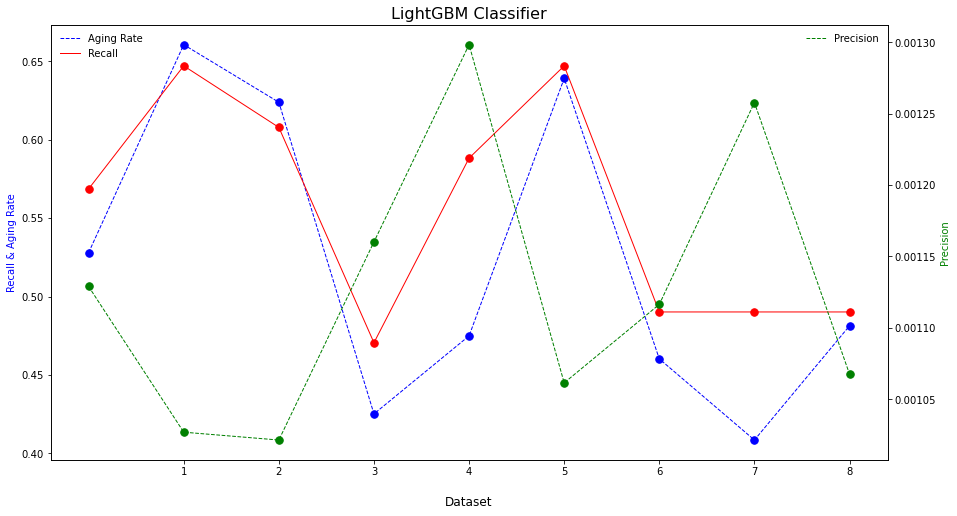

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,F1 Score,Score
dataset1,1.000000,3067.0,3067.0,29.0,25658.0,22.0,22940.0,0.001129,0.568627,0.528007,1.076932,0.001127,0.415605
dataset2,1.000000,2994.0,2994.0,33.0,32102.0,18.0,16496.0,0.001027,0.647059,0.660548,0.979579,0.001025,0.000000
dataset3,1.000000,3038.0,3038.0,31.0,30319.0,20.0,18279.0,0.001021,0.607843,0.623857,0.974331,0.001020,0.000000
dataset4,1.000000,3038.0,3038.0,24.0,20662.0,27.0,27936.0,0.001160,0.470588,0.425209,1.106722,0.001157,0.350651
dataset5,1.006623,3040.0,3020.0,30.0,23076.0,21.0,25522.0,0.001298,0.588235,0.474953,1.238512,0.001296,0.474007
dataset6,1.016043,3040.0,2992.0,33.0,31056.0,18.0,17542.0,0.001061,0.647059,0.639047,1.012537,0.001060,0.452550
dataset7,1.000000,3040.0,3040.0,25.0,22368.0,26.0,26230.0,0.001116,0.490196,0.460297,1.064956,0.001114,0.355445
dataset8,1.000000,3040.0,3040.0,25.0,19851.0,26.0,28747.0,0.001258,0.490196,0.408559,1.199816,0.001255,0.386458
dataset9,10.000000,3040.0,304.0,25.0,23392.0,26.0,25206.0,0.001068,0.490196,0.481346,1.018386,0.001065,0.344264


In [6]:
line_chart(table_setC, title = 'LightGBM Classifier')
table_setC

### Export

In [7]:
savedate = '20220506'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'LightGBM_m2-4_m5'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'LightGBM_m2-4_m5')